# How to Weigh a Black Hole:<br>GW150914 Data Conditioning and Parameter Estimation

### UChicago Physics 386 Final Project Notebook, Spring 2023<br>Sam Dyson (samdyson@uchicago.edu)

This notebook was developed as a UChicago Physics 386 final project. It is an introductory learning tool for using LIGO data to estimate binary black hole (BBH) parameters.

- For a LIGO data analysis guide, see [A guide to LIGO–Virgo detector noise and extraction of transient gravitational-wave signals](https://iopscience.iop.org/article/10.1088/1361-6382/ab685e) (referenced below as "LIGO Guide")
- For an introdution to using LIGO data, see 
    - https://gwosc.org/tutorial01/ 
    - https://gwosc.org/techdetails/
- For GW150914 data specifically, see 
    - https://gwosc.org/events/GW150914/
    - https://gwosc.org/eventapi/html/O1_O2-Preliminary/GW150914/v1/
- For an intro to statistical methods, see Hossein Pishro-Nik's https://www.probabilitycourse.com/ (available as a [PDF here](https://github.com/casrou/ProbToPdf/blob/master/Introduction%20to%20Probability%2C%20Statistics%2C%20and%20Random%20Processes%20-%20Hossein%20Pishro-Nik.pdf) and cited below as e.g. "PN 10.1.4")

Note to self: [Phys 386 OneNote notebook](https://uchicagoedu-my.sharepoint.com/personal/samdyson_uchicago_edu/_layouts/OneNote.aspx?id=%2Fpersonal%2Fsamdyson_uchicago_edu%2FDocuments%2FPhys%20386%20Sets%20-%20Adv%20Data%20Anal&wd=target%28Final%20Project.one%7C45EB13A4-AE89-FF4F-8F3C-E93EBD7DA0C0%2F%29)



## TOC:
* [I. Importing and Checking Data](#I.-Importing-and-Checking-Data)
* [II. Visualizing Data](#II.-Visualizing-Data)
    * [IIA. View 32-Second Time Series from gpdStart](#IIA.-View-32-Second-Time-Series-from-gpdStart)
    * [II.B. View Time Series Centered on GPS Time 1126259462](#II.B.-View-Time-Series-Centered-on-GPS-Time-1126259462)
    * [II.C. Define and Apply a Tukey Window](#II.C.-Define-and-Apply-a-Tukey-Window)
    * [II.D. Fourier Transform and Examine Target Data in the Frequency Domain](#II.D.-Fourier-Transform-and-Examine-Target-Data-in-the-Frequency-Domain)
* [III. Noise Reduction: Whitening and Band-Passing](#III.-Noise-Reduction:-Whitening-and-Band-Passing)
    * [III.A. Apply Welch Averaging to Entire 32-sec Time Stream](#III.A.-Apply-Welch-Averaging-to-Entire-32-sec-Time-Stream)
    * [III.B. Apply Welch Averaging to 1024-sec Time Stream by Hand](#III.B.-Apply-Welch-Averaging-to-1024-sec-Time-Stream-by-Hand)
    * [III.C. Apply Welch Averaging to 1024-sec Time Stream w/ scipy](#III.C.-Apply-Welch-Averaging-to-1024-sec-Time-Stream-w/-scipy)
    * [III.D. Butterworth Band-Pass Filtering and IFFT](#III.D.-Butterworth-Band-Pass-Filtering-and-IFFT)
* [IV. Generate Waveforms and Primary-Mass Posteriors](#IV.-Generate-Waveforms-and-Primary-Mass-Posteriors)
    * [IV.A. Examine Published Posterior Values and Calculate Means](#IV.A.-Examine-Published-Posterior-Values-and-Calculate-Means)
    * [IV.B. Create Time-Domain Model Realizations](#IV.B.-Create-Time-Domain-Model-Realizations)
    * [IV.C. Create Frequency-Domain Model Realizations](#IV.C.-Create-Frequency-Domain-Model-Realizations)
* [V. Parameter Estimation](#V.-Parameter-Estimation)
    * [V.A. Prepare Data Arrays for Parameter Estimation](#V.A.-Prepare-Data-Arrays-for-Parameter-Estimation)
    * [V.B. Create and Apply Butterworth Bandpass Filter to Arrays](#V.B.-Create-and-Apply-Butterworth-Bandpass-Filter-to-Arrays)
    * [V.C. Calculate the Likelihood for Each Model Realization](#V.C.-Calculate-the-Likelihood-for-Each-Model-Realization)
* [Graveyard](#Graveyard)



## I. Importing and Checking Data

- https://www.geeksforgeeks.org/hdf5-files-in-python/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
# Open data file

filename ="H-H1_LOSC_16_V2-1126259446-32.hdf5"
datafile = h5py.File(filename,'r')

In [4]:
# Explore the file
for key in datafile.keys():
    print(key)

meta
quality
strain


In [5]:
# Read in strain data
# strain = datafile['strain']['Strain'].value # Deprecated syntax
strain = datafile['strain']['Strain'][()] # Use this updated syntax instead
dt = datafile['strain']['Strain'].attrs['Xspacing']

In [6]:
# Print out some meta data
metakeys = datafile['meta'].keys()
meta = datafile['meta']
for key in metakeys:
    print(key, meta[key][()])

Description b'Strain data time series from LIGO'
DescriptionURL b'http://losc.ligo.org/'
Detector b'H1'
Duration 32
GPSstart 1126259446
Observatory b'H'
Type b'StrainTimeSeries'
UTCstart b'2015-09-14T09:50:29'


## II. Visualizing Data

- Examine the time-domain strain signal data
- Window the time-domain data to avoid [spectral leakage](https://en.wikipedia.org/wiki/Spectral_leakage) when Fourier transforming to the frequency domain
- Examine the frequency-domain strain signal data (with and without windowing) viewed as a:
    - Strain signal spectrum (in units 1/sqrt(Hz))
    - Strain power spectrum (in 1/Hz)
    - See PN 10.2.1

### IIA. View 32-Second Time Series from gpdStart

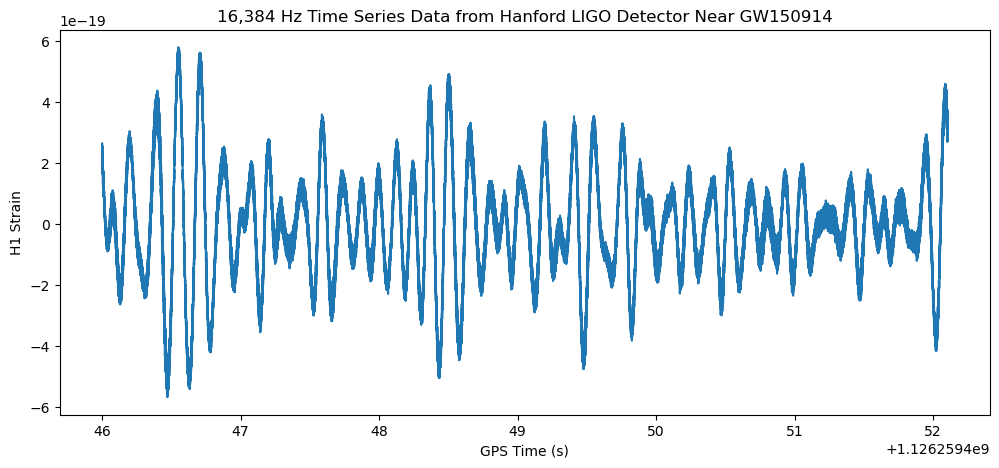

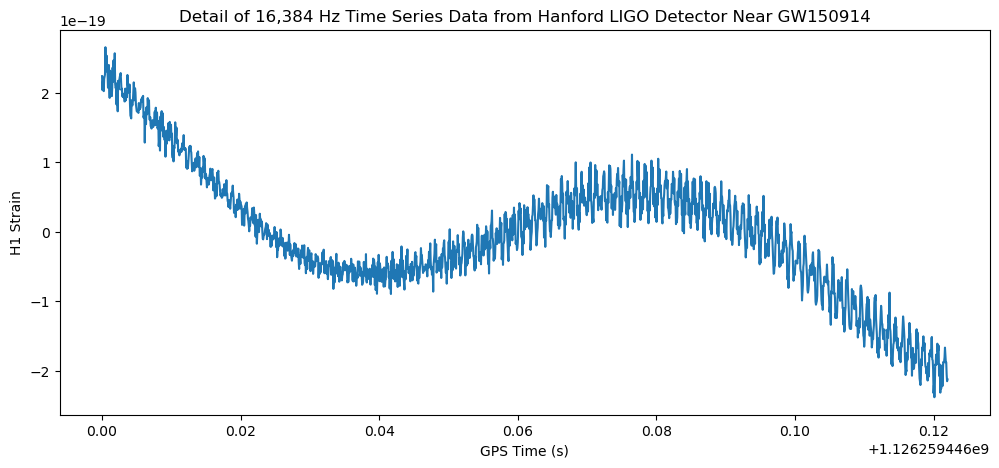

In [7]:
# Create a time vector
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration

time = np.arange(gpsStart, gpsEnd, dt)

# Plot the time series
num_samples = 100000
plt.figure(figsize=(12,5))
plt.plot(time[0:num_samples], strain[0:num_samples])
plt.title("16,384 Hz Time Series Data from Hanford LIGO \
Detector Near GW150914")
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.savefig("Poster Presentation Docs/noisy_timestream_long.png",
            bbox_inches='tight')
plt.show()

# Zoom in on the time series
num_samples2 = 2000
plt.figure(figsize=(12,5))
plt.plot(time[0:num_samples2], strain[0:num_samples2])
plt.title("Detail of 16,384 Hz Time Series Data from Hanford LIGO Detector Near GW150914")
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.savefig("Poster Presentation Docs/noisy_timestream_short.png",
            bbox_inches='tight')
plt.show()


Inspect the arrays of time and strain values

In [8]:
print("time.shape:",time.shape)
for i in range(10):
    print(i,time[i])
for i in range(10):
    print("interval from",i,"to",i+1,time[i+1]-time[i])
time[16384*16]

time.shape: (524288,)
0 1126259446.0
1 1126259446.000061
2 1126259446.000122
3 1126259446.000183
4 1126259446.0002441
5 1126259446.0003052
6 1126259446.0003662
7 1126259446.0004272
8 1126259446.0004883
9 1126259446.0005493
interval from 0 to 1 6.103515625e-05
interval from 1 to 2 6.103515625e-05
interval from 2 to 3 6.103515625e-05
interval from 3 to 4 6.103515625e-05
interval from 4 to 5 6.103515625e-05
interval from 5 to 6 6.103515625e-05
interval from 6 to 7 6.103515625e-05
interval from 7 to 8 6.103515625e-05
interval from 8 to 9 6.103515625e-05
interval from 9 to 10 6.103515625e-05


1126259462.0

In [9]:
print("strain.shape:",strain.shape)
for i in range(10):
    print(i,strain[i])
for i in range(10):
    print("interval from",i,"to",i+1,strain[i+1]-strain[i])

strain.shape: (524288,)
0 2.237498230931858e-19
1 2.0367469531460703e-19
2 2.1595854639488717e-19
3 2.2169038125253014e-19
4 2.0219046359923691e-19
5 2.1971227057802394e-19
6 2.226973578738107e-19
7 2.264039282356545e-19
8 2.6534572025562397e-19
9 2.3027637938292464e-19
interval from 0 to 1 -2.007512777857876e-20
interval from 1 to 2 1.2283851080280146e-20
interval from 2 to 3 5.731834857642967e-21
interval from 3 to 4 -1.9499917653293227e-20
interval from 4 to 5 1.7521806978787027e-20
interval from 5 to 6 2.985087295786747e-21
interval from 6 to 7 3.7065703618438266e-21
interval from 7 to 8 3.894179201996945e-20
interval from 8 to 9 -3.506934087269933e-20
interval from 9 to 10 4.428813761503657e-21


Replot but eliminating the extraneous time digits, subtracting all digits larger than the tens place

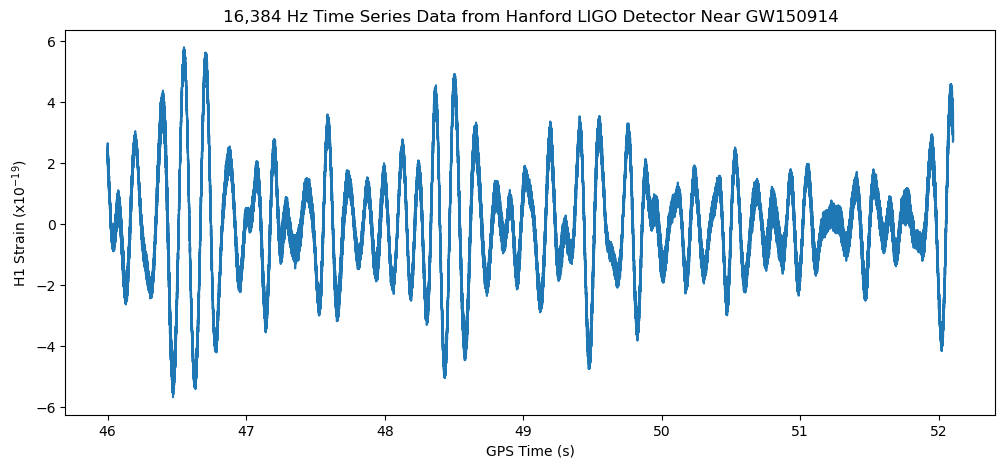

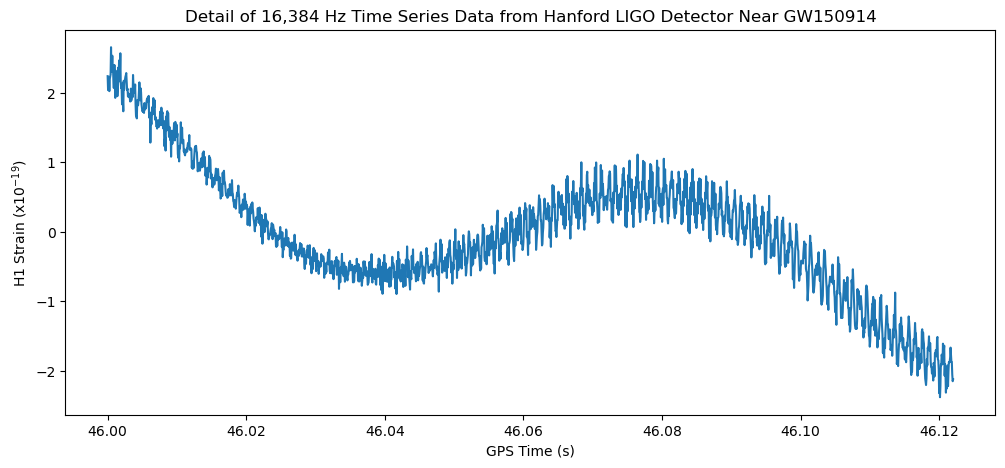

In [10]:
# Create a time vector
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration

time = np.arange(gpsStart, gpsEnd, dt)

# Plot the time series
num_samples = 100000
plt.figure(figsize=(12,5))
# Now eliminating the x-axis extra digits (1126259400 = 1.126e9)
# by subtracting all time digits larger than the tens place
# and eliminating the 1e-19 y-axis label (and updating the ylabel)
plt.plot(time[0:num_samples]-1126259400, 
         strain[0:num_samples]*1e+19)
plt.title("16,384 Hz Time Series Data from Hanford LIGO \
Detector Near GW150914")
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain (x10$^{-19}$)')
plt.savefig("Poster Presentation Docs/noisy_timestream_long.png",
            bbox_inches='tight')
plt.show()

# Zoom in on the time series
num_samples2 = 2000
plt.figure(figsize=(12,5))
plt.plot(time[0:num_samples2]-1126259400, 
         strain[0:num_samples2]*1e19)
plt.title("Detail of 16,384 Hz Time Series Data from Hanford LIGO Detector Near GW150914")
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain (x10$^{-19}$)')
plt.savefig("Poster Presentation Docs/noisy_timestream_short.png",
            bbox_inches='tight')
plt.show()


### II.B. View Time Series Centered on GPS Time 1126259462

Change x-range from -2 to 2 where detection is.

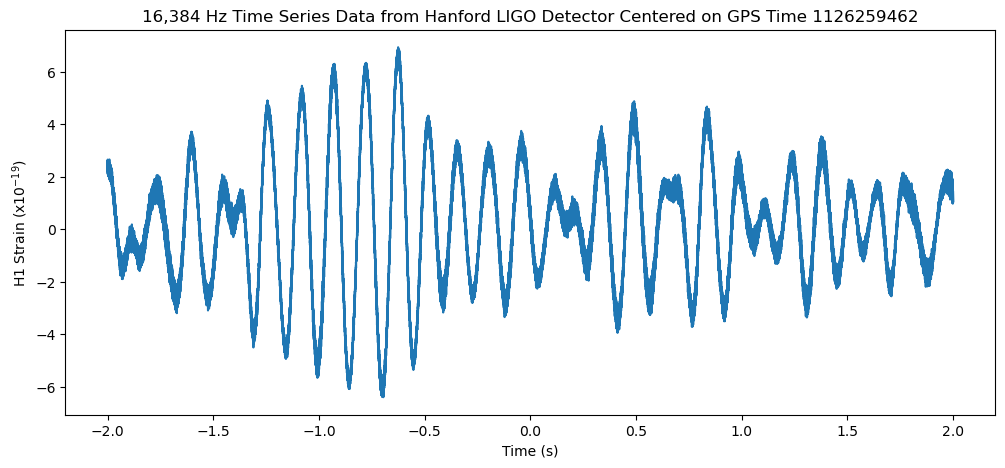

In [11]:
# Plot +/- 2 sec centered on 1126259462
# GPSstart 1126259446
# 16,384 Hz = 6.103515625e-05 s intervals

plus_minus_time_sec = 2
target_times = time[(16384*(16-plus_minus_time_sec)):
                    (16384*(16+plus_minus_time_sec))]
target_strains = strain[(16384*(16-plus_minus_time_sec)):
                        (16384*(16+plus_minus_time_sec))]

# Plot the time series centered on 1126259462.0, 16 sec after gpsStart
plt.figure(figsize=(12,5))
# Center the plot times on the GPS time nearest GW150914
plt.plot(target_times-1126259462,target_strains*1e19)
plt.title("16,384 Hz Time Series Data from Hanford LIGO Detector Centered on GPS Time 1126259462")
plt.xlabel('Time (s)')
plt.ylabel('H1 Strain (x10$^{-19}$)')
plt.show()

#plt.xlim()

### II.C. Define and Apply a Tukey Window

In [12]:
from scipy import signal
#from scipy.fft import fft, fftshift, fftfreq
from scipy import *
import warnings
warnings.filterwarnings('ignore')

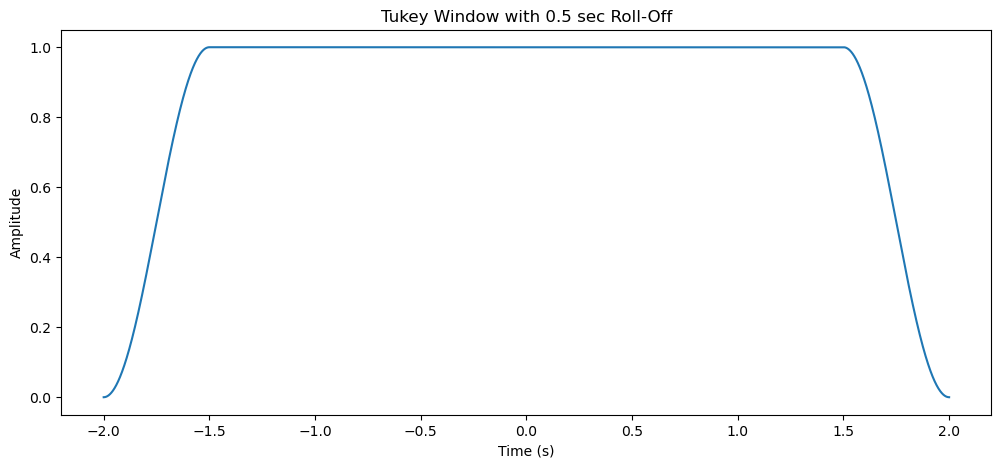

In [13]:
# Define Tukey window
tukey_window = signal.windows.tukey(16384*4,1/4)

# Plot Tukey window
plt.figure(figsize=(12,5))
plt.plot(target_times-1126259462,tukey_window)
plt.title("Tukey Window with 0.5 sec Roll-Off")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

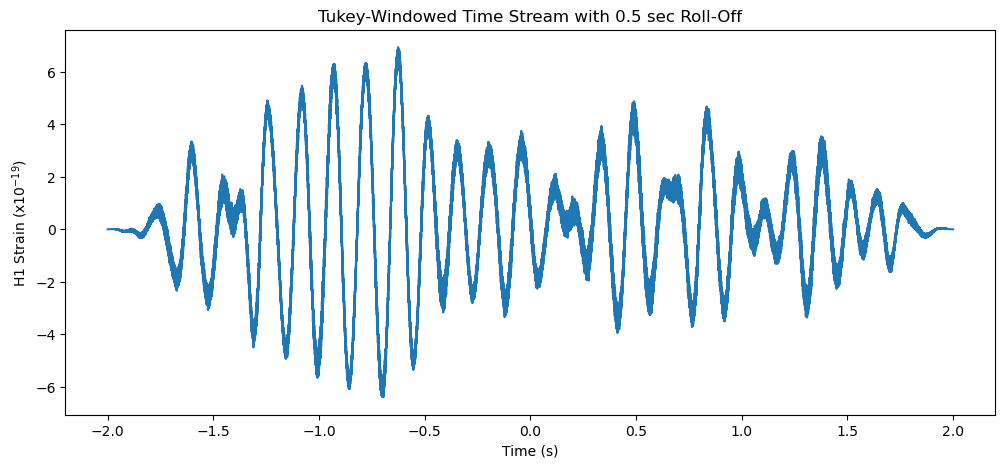

In [14]:
# Plot Tukey windowed timestream
plt.figure(figsize=(12,5))
plt.plot(target_times-1126259462,tukey_window*target_strains*1e19)
plt.title("Tukey-Windowed Time Stream with 0.5 sec Roll-Off")
plt.xlabel("Time (s)")
plt.ylabel("H1 Strain (x10$^{-19}$)")
plt.show()

### II.D. Fourier Transform and Examine Target Data in the Frequency Domain

#### FFT of Non-Windowed Data

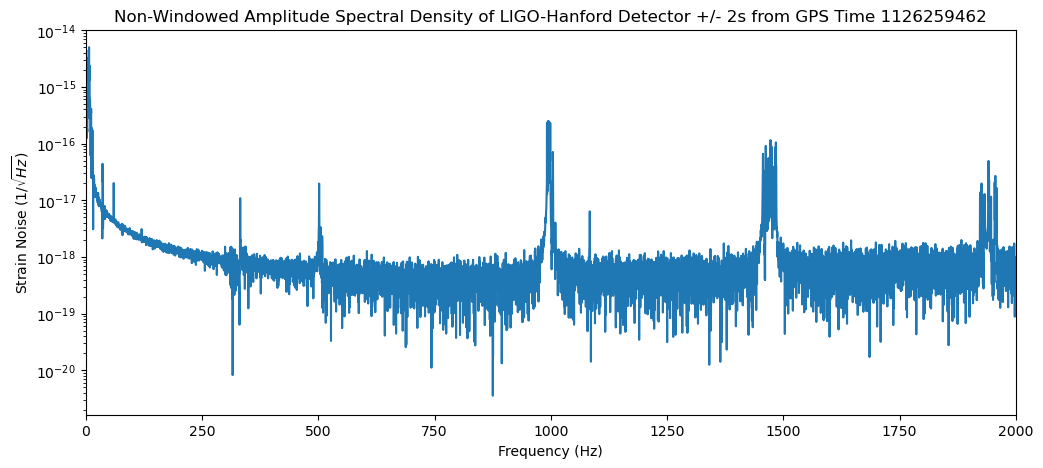

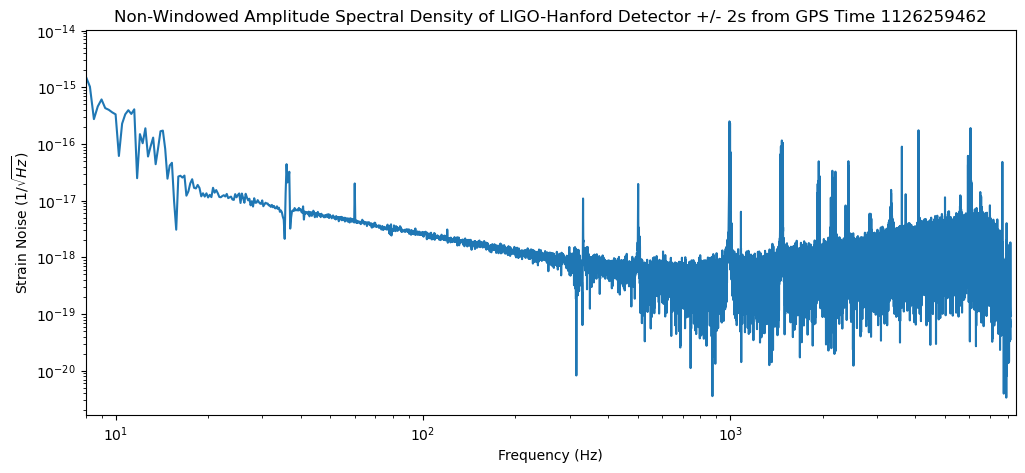

In [15]:
# Axes chosen for comparison with Fig 2 of LIGO Guide paper

# Fourier transform (and shift) target strain and time data
target_freq = fft.fftshift(fft.fftfreq(16384*4,(1/16384)))
target_strains_FFT = fft.fftshift(fft.fft(target_strains))

plt.figure(figsize=(12,5))
plt.plot(target_freq,np.abs(target_strains_FFT))
plt.title("Non-Windowed Amplitude Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Noise $(1/\sqrt{Hz})$")
plt.xlim(0,2000)
#plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(target_freq,(np.abs(target_strains_FFT)))
plt.title("Non-Windowed Amplitude Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Noise $(1/\sqrt{Hz})$")
plt.xlim(8,8500)
plt.xscale("log")
plt.yscale("log")
plt.show()

# plt.figure(figsize=(12,5))
# plt.plot((target_freq),(np.abs(target_strains_FFT)))
# plt.title("Non-Windowed Amplitude Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Strain Noise $(1/\sqrt{Hz})$")
# plt.xlim(8,8500)
# plt.ylim(-1e-16,2e-15)
# plt.xscale("log")
# plt.show()


#### FFT of Tukey-Windowed Data

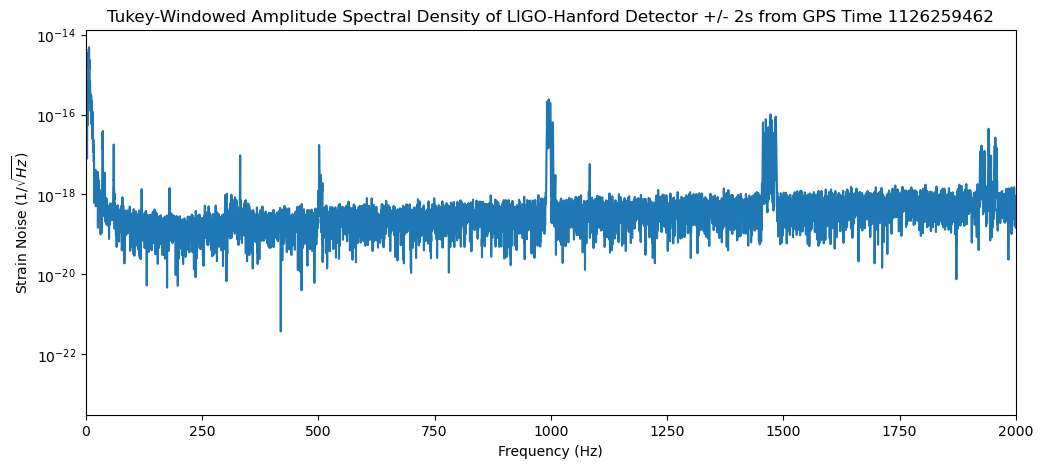

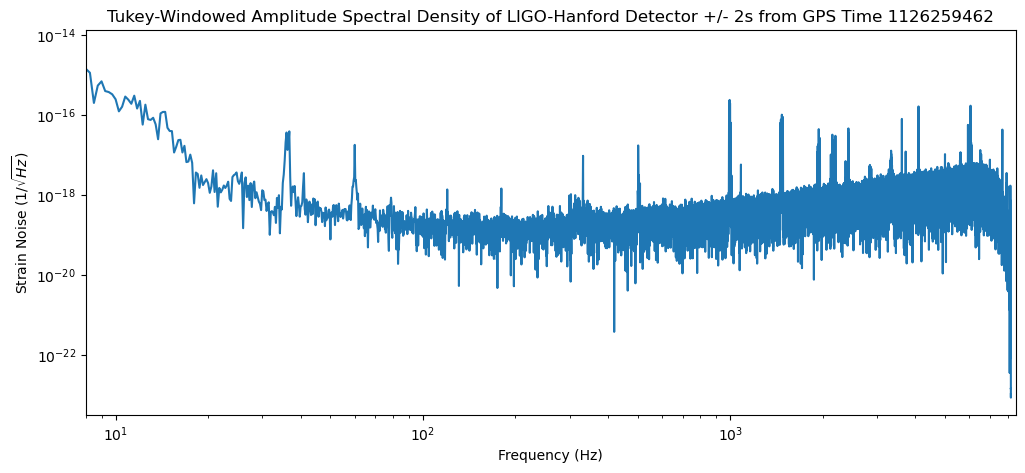

In [16]:
# Amplitude Spectral Density
# Axes chosen for comparison with Fig 2 of LIGO Guide paper

# Fourier transform (and shift) target strain and time data
target_strains_windowed_FFT = fft.fftshift(
    fft.fft(target_strains*tukey_window))

plt.figure(figsize=(12,5))
plt.plot((target_freq),((np.abs(
    target_strains_windowed_FFT))))
plt.title("Tukey-Windowed Amplitude Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Noise $(1/\sqrt{Hz})$")
plt.xlim(0,2000)
#plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(target_freq,(np.abs(target_strains_windowed_FFT)))
plt.title("Tukey-Windowed Amplitude Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Noise $(1/\sqrt{Hz})$")
plt.xlim(8,8500)
plt.xscale("log")
plt.yscale("log")
plt.show()

# plt.figure(figsize=(12,5))
# plt.plot((target_freq),(np.abs(target_strains_windowed_FFT)))
# plt.title("Tukey-Windowed Amplitude Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Strain Noise $(1/\sqrt{Hz})$")
# plt.xlim(8,8500)
# plt.ylim(-1e-16,2e-15)
# plt.xscale("log")
# plt.show()


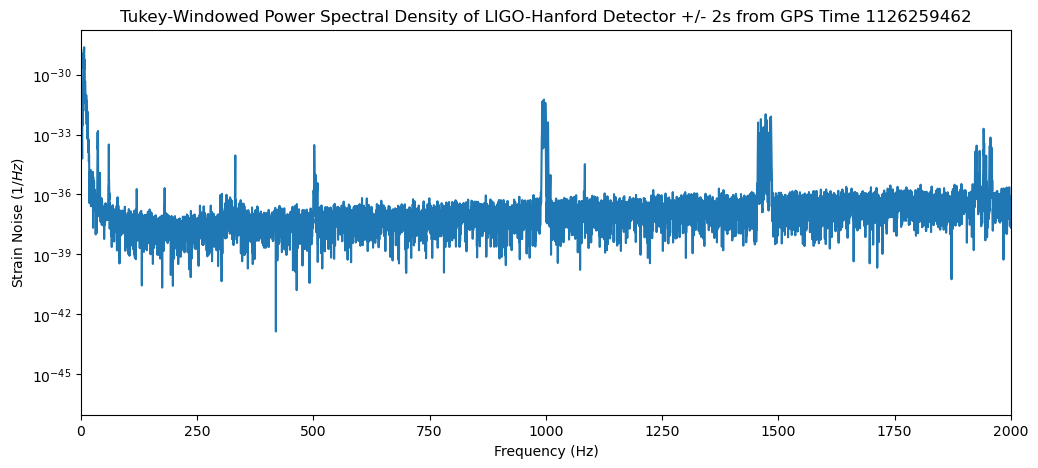

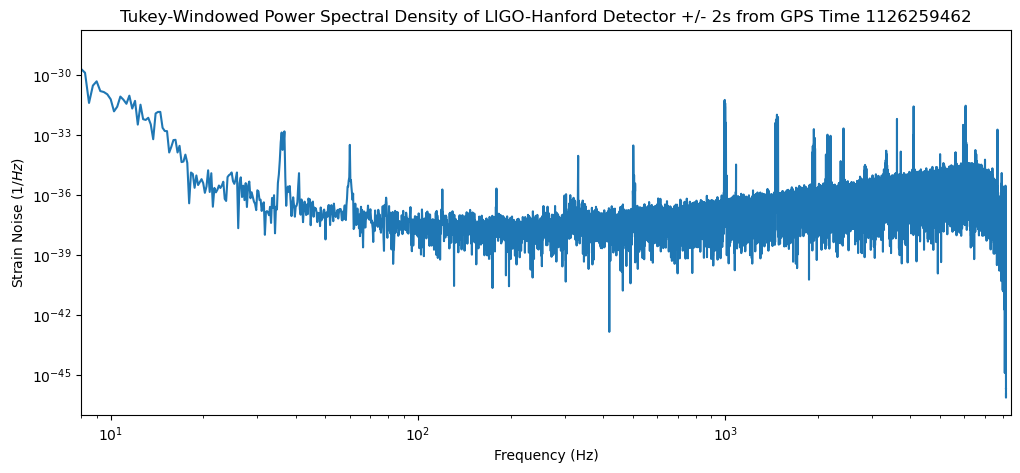

In [17]:
# Power Spectral Density
# Axes chosen for comparison with Fig 2 of LIGO Guide paper


plt.figure(figsize=(12,5))
plt.plot((target_freq),((np.abs(target_strains_windowed_FFT)))**2)
plt.title("Tukey-Windowed Power Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Noise $(1/Hz)$")
plt.xlim(0,2000)
#plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(target_freq,((np.abs(target_strains_windowed_FFT)))**2)
plt.title("Tukey-Windowed Power Spectral Density of LIGO-Hanford Detector +/- 2s from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Noise $(1/Hz)$")
plt.xlim(8,8500)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [18]:
print(target_freq)
print(target_freq.shape)
print(target_strains_FFT)

[-8192.   -8191.75 -8191.5  ...  8191.25  8191.5   8191.75]
(65536,)
[9.39754422e-20-0.00000000e+00j 9.39765268e-20-5.91058010e-23j
 9.39805057e-20-1.19628136e-22j ... 9.39916924e-20+1.74564241e-22j
 9.39805057e-20+1.19628136e-22j 9.39765268e-20+5.91058010e-23j]


## III. Noise Reduction: Whitening and Band-Passing

- Estimate the strain noise via [Welch averaging](https://en.wikipedia.org/wiki/Welch%27s_method) (see LIGO Guide)
- Characterize the detector white noise (PN 10.2.4) and its spectral features as an [ASD or PSD](https://physics.stackexchange.com/questions/615349/amplitude-spectral-density-vs-power-spectral-density)
- Use Butterworth filtering in frequency domain to window desired frequencies

### III.A. Apply Welch Averaging to Entire 32-sec Time Stream

- Using 32-sec, 16,384 Hz data (version 2)
- Averging noise over 28 4-sec intervals shifted by 1-sec increments
- Each Welch averaging interval overlapping the previous one by 3 seconds

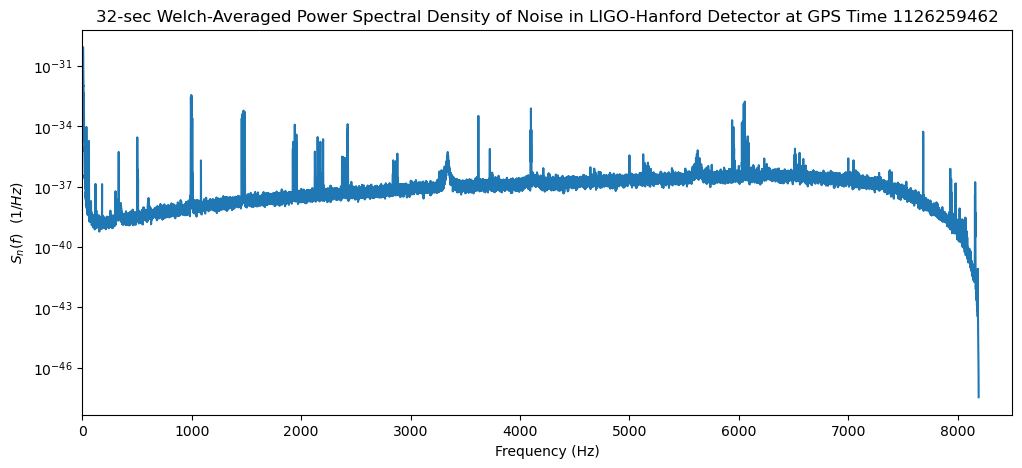

In [19]:
# Apply Welch averaging to full time stream in 
# overlapping 4 s long chunks, each spaced by 1 s

# Initialize a 28 x (16384*4) array to store the spectral data to be Welch averaged
noise_spectra = np.zeros((28,16384*4))

# Loop through the time stream, storing Tukey-windowed, FFT frequencies for each 4-s chunk
for second in range(0,28):
    # Store the strain data
    current_data = strain[(16384*second):(16384*(second+4))]
    #print(current_data.size)

    # Tukey window the strain data
    current_data_windowed = current_data * tukey_window
    
    # FFT the strain data
    current_fft = fft.fftshift(fft.fft(current_data_windowed))
    
    # Store the FFT strain data
    noise_spectra[second] = (2*(np.abs(current_fft))**2)/(32)

# Calculate the average of all 4-sec frequency chunks of data
noise_spectra_avg = np.zeros(16384*4)
for freq in range(0,16384*4):
    noise_spectra_avg[freq] = np.mean(noise_spectra[:,freq])

# Plot the Welch averaged noise frequency spectrum

plt.figure(figsize=(12,5))
plt.plot((target_freq),(noise_spectra_avg))
plt.title("32-sec Welch-Averaged Power Spectral Density of Noise in \
LIGO-Hanford Detector at GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$S_{n}(f) \ \ (1/Hz)$")
plt.xlim(0,8500)
#plt.ylim(-1e-20,1e-17)
plt.yscale("log")
plt.show()


In [20]:
print(noise_spectra.shape)
print(noise_spectra[27].shape)
print(tukey_window.size)
noise_spectra[:,1]
noise_spectra_avg.shape

(28, 65536)
(65536,)
65536


(65536,)

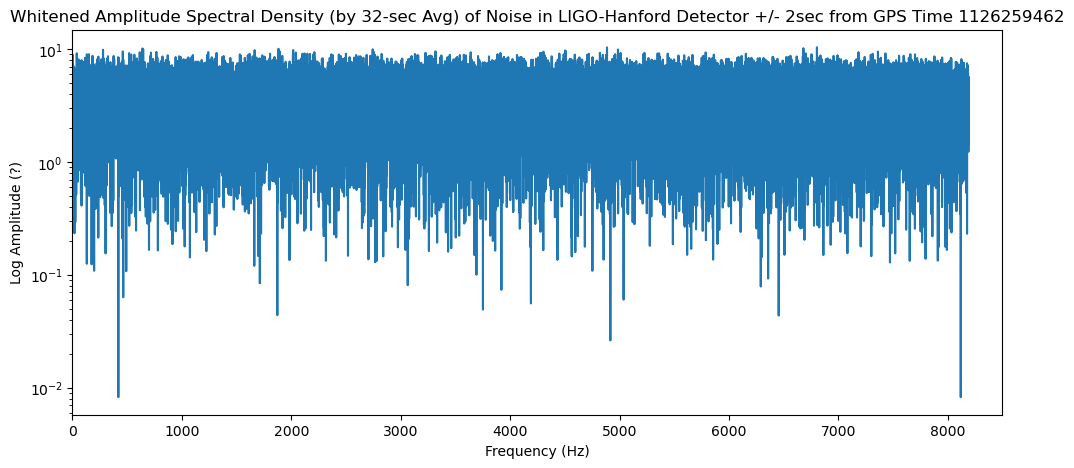

In [21]:
target_strains_windowed_FFT_whitened = \
    target_strains_windowed_FFT/np.sqrt(noise_spectra_avg)

plt.figure(figsize=(12,5))
plt.plot((target_freq),
         ((np.abs(target_strains_windowed_FFT_whitened))))
plt.title("Whitened Amplitude Spectral Density (by 32-sec Avg) \
of Noise in LIGO-Hanford Detector +/- 2sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Amplitude (?)")
#plt.xscale("log")
plt.yscale("log")
plt.xlim(0,8500)
#plt.ylim(-1e-20,1e-17)
plt.show()


### III.B. Apply Welch Averaging to 1024-sec Time Stream by Hand

- Using 1024-sec, 16,384 Hz data (version 2)
- Averaging noise over 511 4-sec intervals shifted by 2-sec increments
- Each Welch averaging interval overlapping the previous one by 2 seconds

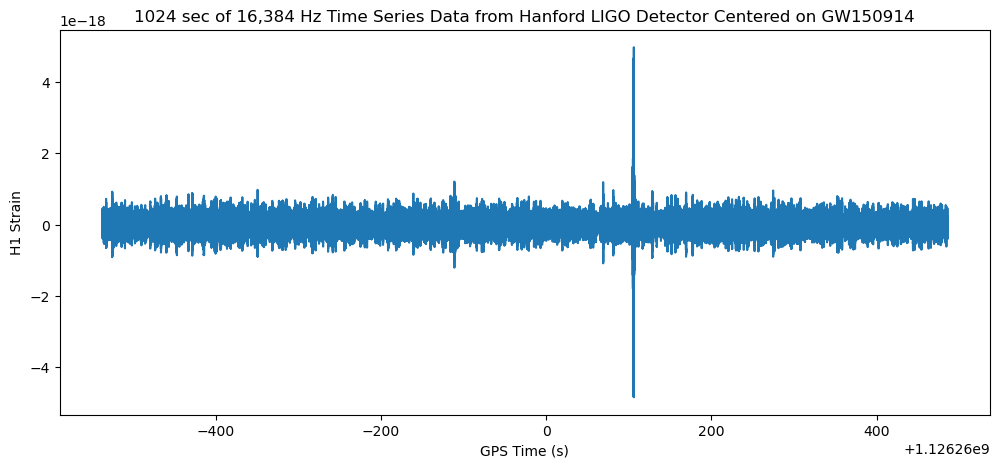

In [22]:
# Open data file

filename4096 ="H-H1_LOSC_16_V2-1126257414-4096.hdf5"
datafile4096 = h5py.File(filename4096,'r')

# Read in strain data
# strain = datafile['strain']['Strain'].value # Deprecated syntax
strain4096 = datafile4096['strain']['Strain'][()] # Use this updated syntax instead
dt4096 = datafile4096['strain']['Strain'].attrs['Xspacing']

# Store some meta data
metakeys4096 = datafile4096['meta'].keys()
meta4096 = datafile4096['meta']

# Create a time vector
gpsStart4096 = meta4096['GPSstart'][()]
duration4096 = meta4096['Duration'][()]
gpsEnd4096   = gpsStart4096 + duration4096

time4096 = np.arange(gpsStart4096, gpsEnd4096, dt4096)

# Index for target GPS time 1126259462.0: time1024[16384*2048]
# Index for 512 sec earlier: time1024[16384*(2048-512)]
# Index for 512 sec later: time1024[16384*(2048+512)]

time1024=time4096[16384*(2048-512):16384*(2048+512)]
strain1024=strain4096[16384*(2048-512):16384*(2048+512)]

# Plot the time series
plt.figure(figsize=(12,5))
plt.plot(time1024+512, # "+512" shifts t=0 to target time of GW150914
         strain1024)
plt.title("1024 sec of 16,384 Hz Time Series Data from Hanford LIGO Detector Centered on GW150914")
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()


In [23]:
# Inspect 1024-sec of time series data

print("time1024.shape:",time1024.shape)
print("strain1024.shape:",strain1024.shape)
print("16777216/16384=",16777216/16384)
print("time4096.shape:",time4096.shape)
print("strain4096.shape:",strain4096.shape)
print("67108864/16384=",67108864/16384)
print("duration4096:",duration4096)
print("time4096[16384*(2048)]=",time4096[16384*(2048)])
print("time4096[16384*(2048+512)]=",time4096[16384*(2048+512)])
print("time4096[16384*(2048+512)]-time4096[16384*(2048)]=",
      time4096[16384*(2048+512)]-time4096[16384*(2048)])

time1024.shape: (16777216,)
strain1024.shape: (16777216,)
16777216/16384= 1024.0
time4096.shape: (67108864,)
strain4096.shape: (67108864,)
67108864/16384= 4096.0
duration4096: 4096
time4096[16384*(2048)]= 1126259462.0
time4096[16384*(2048+512)]= 1126259974.0
time4096[16384*(2048+512)]-time4096[16384*(2048)]= 512.0


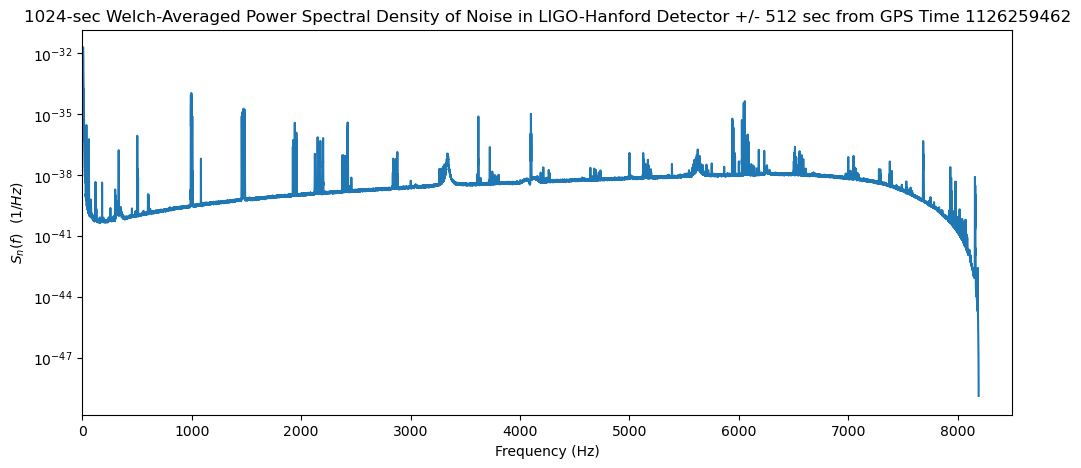

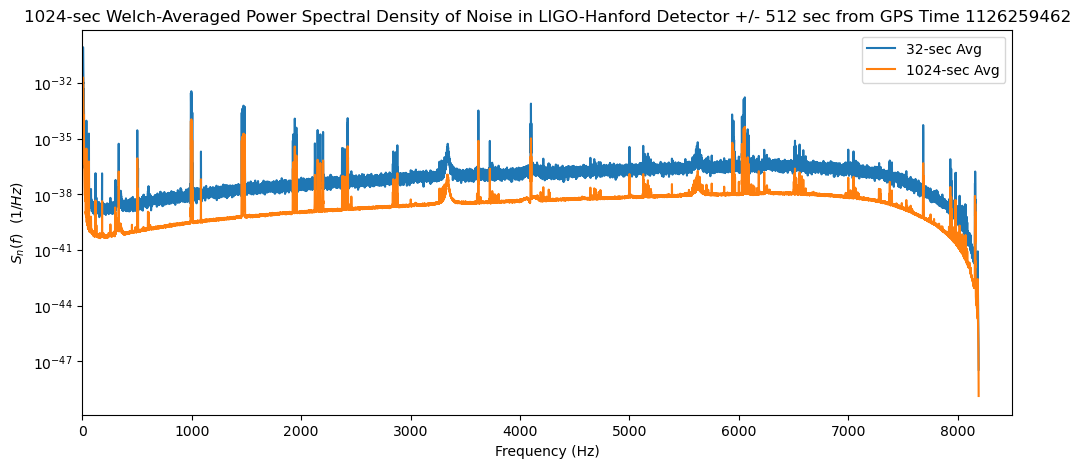

In [24]:
# Apply Welch averaging to 1024-s time stream in 
# overlapping 4 s long chunks, each spaced by 2 s

# Initialize a (512-1) x (16384*4) array to store the 
# spectral data to be Welch averaged
noise_spectra1024 = np.zeros((512-1,16384*4))

# Loop through the time stream, storing Tukey-windowed, 
# FFT frequencies for each 4-s chunk
for second1024 in range(0,512-1):
    # Store the strain data
    current_data1024 = strain1024[(16384*second1024*2):
                                  (16384*(second1024*2+4))]
    #print("current_data1024.size:",current_data1024.size)
    #print("tukey_window.size:",tukey_window.size)

    # Tukey window the strain data
    current_data_windowed1024 = current_data1024 * tukey_window
    
    # FFT the strain data
    current_fft1024 = fft.fftshift(fft.fft(current_data_windowed1024))
    
    # Store the periodogram data for this chunk, which equals
    # |S(f)^2|/T (see Saulson p. 53)
    noise_spectra1024[second1024] = (2*(np.abs(current_fft1024))**2)/(
        1024)

# Calculate the average of all 4-sec frequency chunks of data
noise_spectra_avg1024 = np.zeros(16384*4)
for freq1024 in range(0,16384*4):
    noise_spectra_avg1024[freq1024] = np.mean(
        noise_spectra1024[:,freq1024])

# Plot the Welch averaged noise frequency spectrum

plt.figure(figsize=(12,5))
plt.plot((target_freq),
         (noise_spectra_avg1024))
plt.title("1024-sec Welch-Averaged Power Spectral Density of Noise \
in LIGO-Hanford Detector +/- 512 sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$S_{n}(f) \ \ (1/Hz)$")
plt.xlim(0,8500)
#plt.ylim(-1e-20,1e-17)
plt.yscale("log")
plt.show()

# Compare two Welch averaging noise spectra 
plt.figure(figsize=(12,5))
plt.plot((target_freq),
         (((noise_spectra_avg))), 
         label="32-sec Avg")
plt.plot((target_freq),
         (((noise_spectra_avg1024))), 
         label="1024-sec Avg")
plt.title("1024-sec Welch-Averaged Power Spectral Density of Noise \
in LIGO-Hanford Detector +/- 512 sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$S_{n}(f) \ \ (1/Hz)$")
plt.xlim(0,8500)
#plt.ylim(-1e-20,1e-17)
plt.yscale("log")
plt.legend()
plt.savefig("Poster Presentation Docs/noise_psd.png",
            bbox_inches='tight')
plt.show()



In [25]:
# Inspect arrays from code above

print("tukey_window.shape",tukey_window.shape)
print("current_data1024.shape",current_data1024.shape)

tukey_window.shape (65536,)
current_data1024.shape (65536,)


In [26]:
noise_spectra1024[510,:]

array([1.22816911e-52, 4.33156067e-50, 1.04066709e-49, ...,
       6.31385730e-49, 1.04066709e-49, 4.33156067e-50])

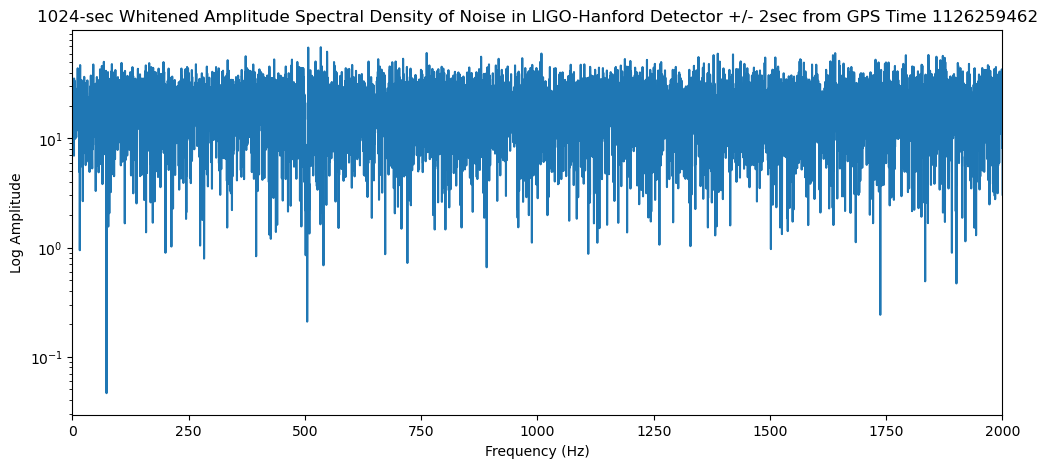

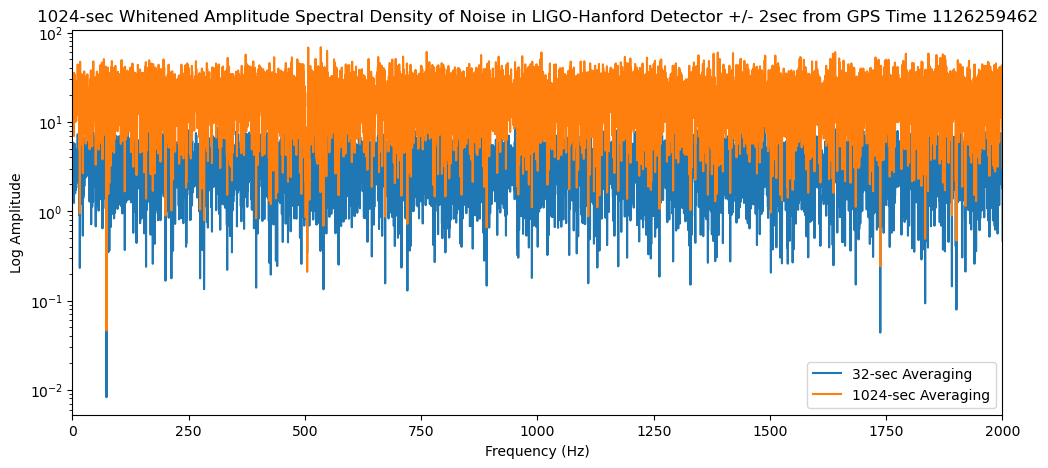

In [27]:
target_strains_windowed_FFT_whitened1024 = \
    target_strains_windowed_FFT/np.sqrt(noise_spectra_avg1024)

plt.figure(figsize=(12,5))
plt.plot((target_freq),(fft.fftshift(np.abs(
    target_strains_windowed_FFT_whitened1024))))
plt.title("1024-sec Whitened Amplitude Spectral Density of Noise \
in LIGO-Hanford Detector +/- 2sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Amplitude")
#plt.xscale("log")
plt.yscale("log")
plt.xlim(0,2000)
#plt.ylim(-1e-20,1e-17)
plt.show()


#Compare whitening by different Welch averaging
plt.figure(figsize=(12,5))
plt.plot((target_freq),(fft.fftshift(np.abs(
    target_strains_windowed_FFT_whitened))), 
         label="32-sec Averaging")
plt.plot((target_freq),(fft.fftshift(np.abs(
    target_strains_windowed_FFT_whitened1024))), 
         label="1024-sec Averaging")
plt.title("1024-sec Whitened Amplitude Spectral Density of Noise \
in LIGO-Hanford Detector +/- 2sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Amplitude")
#plt.xscale("log")
plt.yscale("log")
plt.xlim(0,2000)
#plt.ylim(0,1e2)
plt.legend()
plt.show()


### III.C. Apply Welch Averaging to 1024-sec Time Stream w/ scipy

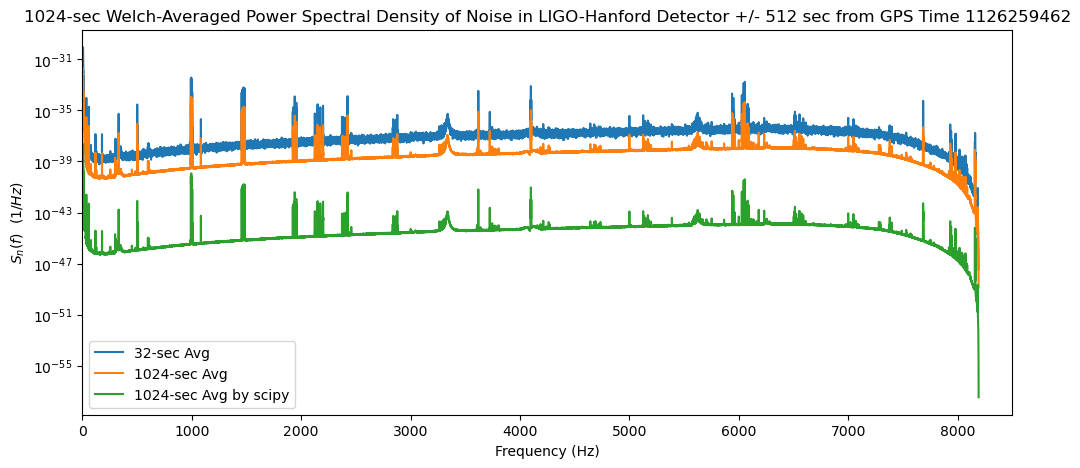

In [28]:
# Use scipy to generate the Welch-averaged noise PSD from 1024 segment

target_freq_byscipy, noise_spectra_avg1024_byscipy = signal.welch(
    x=strain1024, fs=16384, window=("tukey",65536),
#   I want:  x=strain1024, fs=16384, window=("tukey",65536,0.25),
    nperseg=65536, noverlap=32768)


target_freq_byscipy = (target_freq_byscipy)
target_strains_FFT_byscipy = (noise_spectra_avg1024_byscipy)

# Compare manual and scipy Welch averaging noise spectra 
plt.figure(figsize=(12,5))
plt.plot((target_freq),
         (((noise_spectra_avg))), 
         label="32-sec Avg")
plt.plot((target_freq),
         (((noise_spectra_avg1024))), 
         label="1024-sec Avg")
plt.plot((target_freq_byscipy),
         (((noise_spectra_avg1024_byscipy))), 
         label="1024-sec Avg by scipy")
plt.title("1024-sec Welch-Averaged Power Spectral Density of Noise \
in LIGO-Hanford Detector +/- 512 sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$S_{n}(f) \ \ (1/Hz)$")
plt.xlim(0,8500)
#plt.ylim(-1e-20,1e-17)
plt.yscale("log")
plt.legend()
plt.show()

In [29]:
target_freq

array([-8192.  , -8191.75, -8191.5 , ...,  8191.25,  8191.5 ,  8191.75])

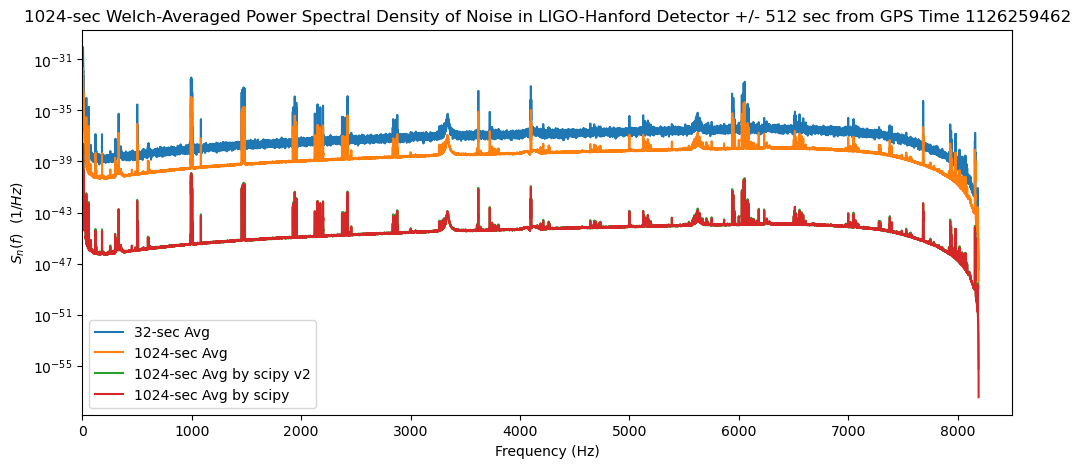

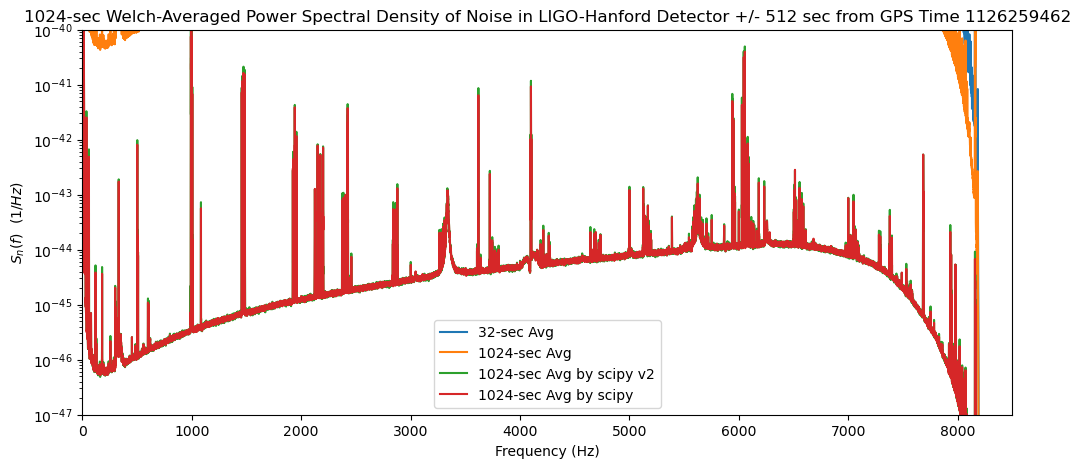

In [30]:
# Use scipy to generate the Welch-averaged noise PSD from 1024 segment

target_freq_byscipy, noise_spectra_avg1024_byscipy = signal.welch(
    x=strain1024, fs=16384, window=("tukey",65536),
#   I want:  x=strain1024, fs=16384, window=("tukey",65536,0.25),
    nperseg=65536, noverlap=32768)

target_freq_byscipy2, noise_spectra_avg1024_byscipy2 = signal.welch(
    x=strain1024, fs=16384, window=tukey_window,
#   I want:  x=strain1024, fs=16384, window=("tukey",65536,0.25),
    nperseg=65536, noverlap=32768)

target_strains_FFT_byscipy = (noise_spectra_avg1024_byscipy)
target_strains_FFT_byscipy2 = (noise_spectra_avg1024_byscipy2)

# Compare manual and scipy Welch averaging noise spectra 
plt.figure(figsize=(12,5))
plt.plot((target_freq),
         (((noise_spectra_avg))), 
         label="32-sec Avg")
plt.plot((target_freq),
         (((noise_spectra_avg1024))), 
         label="1024-sec Avg")
plt.plot((target_freq_byscipy2),
         (((noise_spectra_avg1024_byscipy2))), 
         label="1024-sec Avg by scipy v2")
plt.plot((target_freq_byscipy),
         (((noise_spectra_avg1024_byscipy))), 
         label="1024-sec Avg by scipy")
plt.title("1024-sec Welch-Averaged Power Spectral Density of Noise \
in LIGO-Hanford Detector +/- 512 sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$S_{n}(f) \ \ (1/Hz)$")
plt.xlim(0,8500)
#plt.ylim(1e-47,1e-40)
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot((target_freq),
         (((noise_spectra_avg))), 
         label="32-sec Avg")
plt.plot((target_freq),
         (((noise_spectra_avg1024))), 
         label="1024-sec Avg")
plt.plot((target_freq_byscipy2),
         (((noise_spectra_avg1024_byscipy2))), 
         label="1024-sec Avg by scipy v2")
plt.plot((target_freq_byscipy),
         (((noise_spectra_avg1024_byscipy))), 
         label="1024-sec Avg by scipy")
plt.title("1024-sec Welch-Averaged Power Spectral Density of Noise \
in LIGO-Hanford Detector +/- 512 sec from GPS Time 1126259462")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$S_{n}(f) \ \ (1/Hz)$")
plt.xlim(0,8500)
plt.ylim(1e-47,1e-40)
plt.yscale("log")
plt.legend()
plt.show()

### III.D. Butterworth Band-Pass Filtering and IFFT

In [31]:
target_strains_windowed_FFT_whitened1024.shape
target_freq.shape

(65536,)

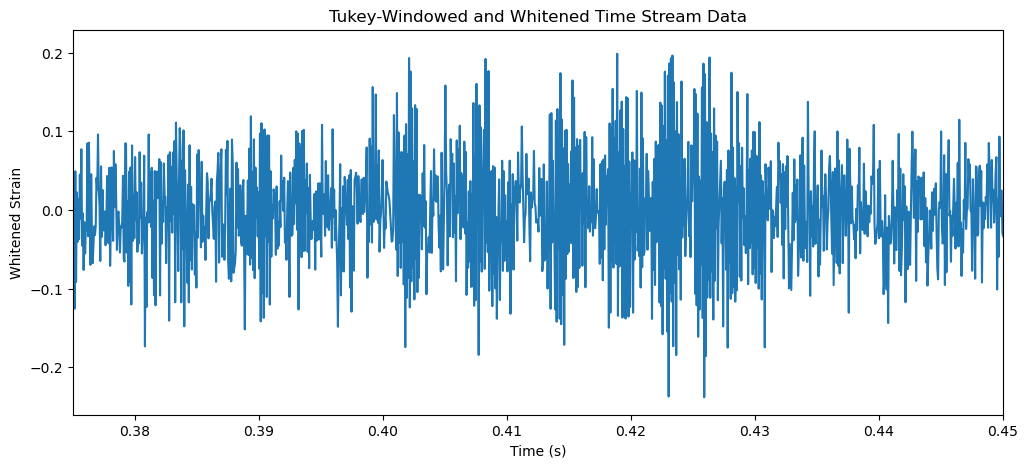

In [32]:
target_strains_windowed_FFT_whitened1024[target_freq>350]=0
# target_strains_windowed_FFT_whitened1024[target_freq<35]=0
target_strains_windowed_whitened1024 = (fft.ifft(
    (target_strains_windowed_FFT_whitened1024)))
#     (target_strains_windowed_FFT_whitened1024)*np.abs(h)))

plt.figure(figsize=(12,5))
plt.plot(target_times-target_times[0]-2,
         target_strains_windowed_whitened1024)
plt.title("Tukey-Windowed and Whitened Time Stream Data")
plt.xlabel("Time (s)")
plt.ylabel("Whitened Strain")
#plt.yscale("log")
#plt.xscale("log")
plt.xlim(0.375,.45)
plt.savefig("Poster Presentation Docs/timestream_signal.png",
            bbox_inches='tight')
plt.show()

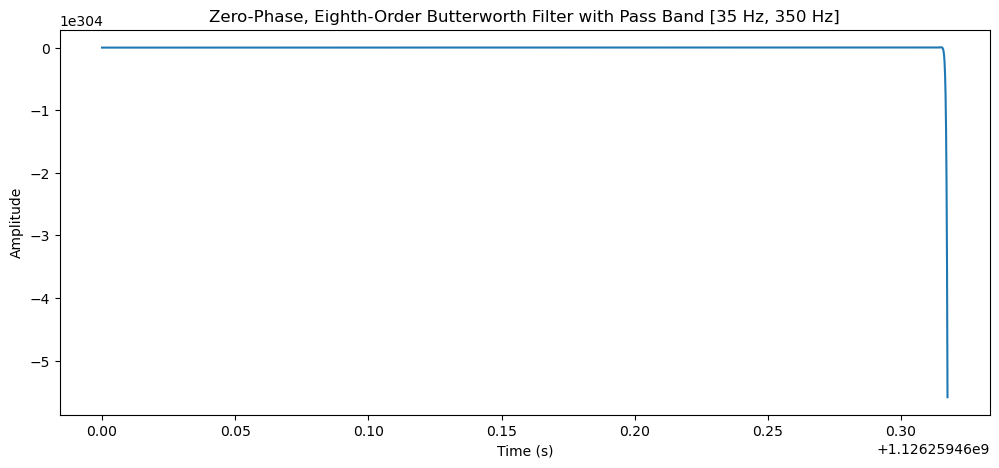

In [33]:
# Define Butterworth windowing band-pass filter in the freq domain
#butterworth_window_a, butterworth_window_b = signal.butter(8,[35,350],btype='band',fs=16384,output='sos')
#butterworth_window = signal.butter(8,[35,350],btype='band',fs=16384,output='sos')
(B,A) = signal.butter(8, [35/(16384/2.0), 350/(16384/2.0)], btype='pass')
target_strains_windowed_whitened_buttered1024 = signal.lfilter(
    B, A, target_strains_windowed_whitened1024)


# Plot Butterworth window
plt.figure(figsize=(12,5))
plt.plot(target_times,target_strains_windowed_whitened_buttered1024)
plt.title("Zero-Phase, Eighth-Order Butterworth Filter with Pass Band [35 Hz, 350 Hz]")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
#plt.yscale("log")
#plt.xscale("log")
plt.show()

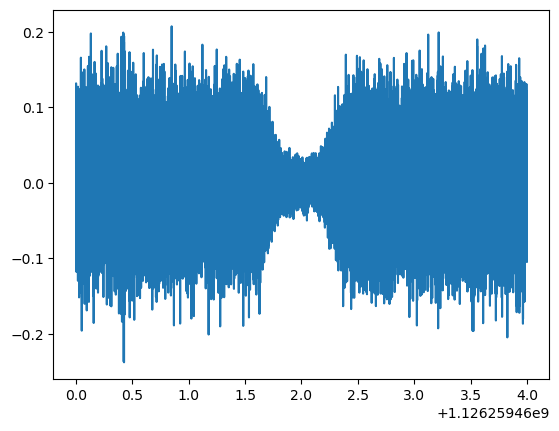

In [34]:
plt.plot(target_times, fft.ifftshift(fft.ifft((target_strains_windowed_FFT_whitened1024))))

## IV. Generate Waveforms and Primary-Mass Posteriors

- Install PyCBC if necessary
    - Code from https://pycbc.org/pycbc/latest/html/detector.html#antenna-patterns-and-projecting-a-signal-into-the-detector-frame, excluding last block of code on this webpage
- Compare noise PSD in the freq domain with freq-domain theoretical waveforms
- Reference [published results](https://zenodo.org/record/6513631) for use of select detection parameters (not mass)

In [35]:
# !pip install pycbc
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

Exception ignored in: redirect_stdouterr(): tmpfile() failed
 '_wrap_delete_FrDetector'
Traceback (most recent call last):
  File "/Users/samueledyson/anaconda3/lib/python3.11/site-packages/lal/__init__.py", line 26, in <genexpr>
    cached_detector_by_prefix = dict((cd.frDetector.prefix, cd) for cd in CachedDetectors)
                                      ^^^^^^^^^^^^^^^^^^^^
RuntimeError: swiglal_redirect_stdouterr() failed
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### IV.A. Examine Published Posterior Values and Calculate Means

In [36]:
# Download this file from https://zenodo.org/record/6513631
f = h5py.File('IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5')

#f.keys()
#f['C01:IMRPhenomXPHM']['posterior_samples'][()]
# f['C01:IMRPhenomXPHM']['posterior_samples'].dtype
f['C01:IMRPhenomXPHM']['posterior_samples'][()].dtype
# f['C01:IMRPhenomXPHM'].keys()

dtype([('chirp_mass', '<f8'), ('mass_ratio', '<f8'), ('a_1', '<f8'), ('a_2', '<f8'), ('tilt_1', '<f8'), ('tilt_2', '<f8'), ('phi_12', '<f8'), ('phi_jl', '<f8'), ('theta_jn', '<f8'), ('psi', '<f8'), ('phase', '<f8'), ('azimuth', '<f8'), ('zenith', '<f8'), ('recalib_H1_amplitude_0', '<f8'), ('recalib_H1_amplitude_1', '<f8'), ('recalib_H1_amplitude_2', '<f8'), ('recalib_H1_amplitude_3', '<f8'), ('recalib_H1_amplitude_4', '<f8'), ('recalib_H1_amplitude_5', '<f8'), ('recalib_H1_amplitude_6', '<f8'), ('recalib_H1_amplitude_7', '<f8'), ('recalib_H1_amplitude_8', '<f8'), ('recalib_H1_amplitude_9', '<f8'), ('recalib_H1_phase_0', '<f8'), ('recalib_H1_phase_1', '<f8'), ('recalib_H1_phase_2', '<f8'), ('recalib_H1_phase_3', '<f8'), ('recalib_H1_phase_4', '<f8'), ('recalib_H1_phase_5', '<f8'), ('recalib_H1_phase_6', '<f8'), ('recalib_H1_phase_7', '<f8'), ('recalib_H1_phase_8', '<f8'), ('recalib_H1_phase_9', '<f8'), ('recalib_L1_amplitude_0', '<f8'), ('recalib_L1_amplitude_1', '<f8'), ('recalib_L1_am

In [37]:
mass_ratio = f['C01:IMRPhenomXPHM']['posterior_samples'][()]["mass_ratio"]
print("mass_ratio.shape:",mass_ratio.shape)
print("np.mean(mass_ratio):",np.mean(mass_ratio))

mass_ratio.shape: (147634,)
np.mean(mass_ratio): 0.8307741710658761


In [38]:
parameters=("ra","dec","psi","viewing_angle","H1_time",
           "mass_2","luminosity_distance")

for parameter_name in parameters:
    current_parameter = f['C01:IMRPhenomXPHM']['posterior_samples'][()][parameter_name]
    print("current_parameter.shape:",current_parameter.shape)
    print("np.mean(",parameter_name,"):",np.mean(current_parameter))

# ra = 1.7
# dec = 1.7
# pol = 0.2
# inc = 0
# time = 1000000000
# mass1=10, mass2=10,
# f_lower=30, delta_f=1.0/16384, inclination=inc,
# distance=400

current_parameter.shape: (147634,)
np.mean( ra ): 1.7473731391015275
current_parameter.shape: (147634,)
np.mean( dec ): -1.1863113354482382
current_parameter.shape: (147634,)
np.mean( psi ): 1.501041951560141
current_parameter.shape: (147634,)
np.mean( viewing_angle ): 0.46524887993865477
current_parameter.shape: (147634,)
np.mean( H1_time ): 1126259462.423953
current_parameter.shape: (147634,)
np.mean( mass_2 ): 31.8201770433512
current_parameter.shape: (147634,)
np.mean( luminosity_distance ): 454.23284333190617


### IV.B. Create Time-Domain Model Realizations

In [39]:
# Calculate the time-domain waveform for these model parameters
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform

# Time, orientation and location of the source in the sky
ra = 1.7473731391015275
dec = -1.1863113354482382
pol = 1.501041951560141
inc = 0.46524887993865477
time = 1126259462.423953

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors above allow us to project a signal into what 
# the detector would observe

## Generate a waveform, the intrinsic signal
hp, hc = get_td_waveform(approximant="IMRPhenomD", 
                         mass1=34, 
                         mass2=31.8201770433512,
                         f_lower=30, 
                         delta_t=1/16384, 
                         inclination=inc,
                         distance=454.23284333190617)

## Apply the factors to get the detector frame strain
ht = fp * hp + fc * hc
ht.shape


fp=-0.08203431228266732, fc=-0.683443506564472


(262144,)

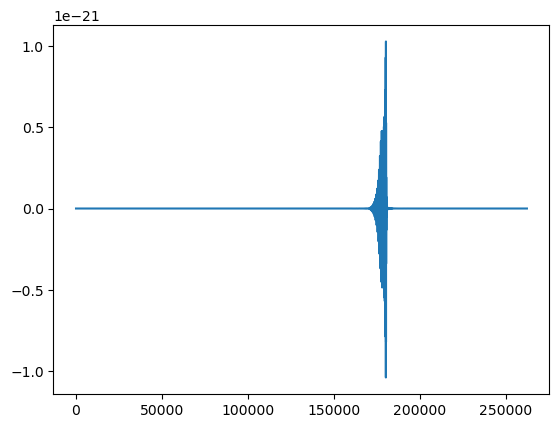

In [40]:
# Plot the time-domain signal
plt.plot(ht)
#plt.xscale("log")
plt.show()

This next cell keeps crashing (matrix dimensions). Fix it or skip it

In [41]:
mass_1_array = np.linspace(24,33.8,50)
ht_all = np.zeros((100,32768))
index = 0

for current_mass_1 in mass_1_array:
    print(mass_1_array)

    ## Generate a waveform, the intrinsic signal
    hp, hc = get_td_waveform(approximant="IMRPhenomD", 
                             mass1=current_mass_1, 
                             mass2=31.8201770433512,
                             f_lower=30, 
                             delta_t=1/16384, 
                             inclination=inc,
                             distance=454.23284333190617)

    ## Apply the factors to get the detector frame strain
    ht = fp * hp + fc * hc
    print(index,ht.shape)
    ht_all[index,:] = ht
    index +=1

plt.figure(figsize=(12,5))
plt.plot(ht_all[0],label="$M_1=24$ $M_{\odot}$")
# plt.plot(ht_all[25])
plt.plot(ht_all[49],label="$M_1=34$ $M_{\odot}$")
plt.xlim(15000,30000)
plt.xlabel("Time (arb)")
plt.ylabel("Amplitude (arb)")
plt.title("Two Time-Domain Model Realizations")
plt.legend()
plt.yticks([])
plt.xticks([])
plt.savefig("Poster Presentation Docs/model_waveform.png",
            bbox_inches='tight')
plt.show()

[24.  24.2 24.4 24.6 24.8 25.  25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6
 26.8 27.  27.2 27.4 27.6 27.8 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4
 29.6 29.8 30.  30.2 30.4 30.6 30.8 31.  31.2 31.4 31.6 31.8 32.  32.2
 32.4 32.6 32.8 33.  33.2 33.4 33.6 33.8]
0 (262144,)


ValueError: could not broadcast input array from shape (262144,) into shape (32768,)

In [42]:
print("32768/(16384):",32768/(16384))
print("1/16384:",1/16384)
print("(32768+1)/(16384):",(32768+1)/(16384))

32768/(16384): 2.0
1/16384: 6.103515625e-05
(32768+1)/(16384): 2.00006103515625


### IV.C. Create Frequency-Domain Model Realizations

In [43]:
# Calculate the frequency-domain waveform for these model parameters
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_fd_waveform

# These attena patter coefficients fp and fc allow us to project 
# a signal into what the detector would observe

# Time, orientation and location of the source in the sky
ra = 1.7473731391015275
dec = -1.1863113354482382
pol = 1.501041951560141
inc = 0.46524887993865477
time = 1126259462.423953

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))


## Generate a waveform, the intrinsic signal
# hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=10, mass2=10,
hp, hc = get_fd_waveform(approximant="IMRPhenomD", 
                         mass1=34, 
                         mass2=31.8201770433512,
                         f_lower=30, 
                         delta_f=0.25, 
                         inclination=inc,
                         distance=454.23284333190617)

## Apply the factors to get the detector frame strain
# ht = fp * hp + fc * hc
hf = fp * hp + fc * hc
hf.shape


fp=-0.08203431228266732, fc=-0.683443506564472


(4097,)

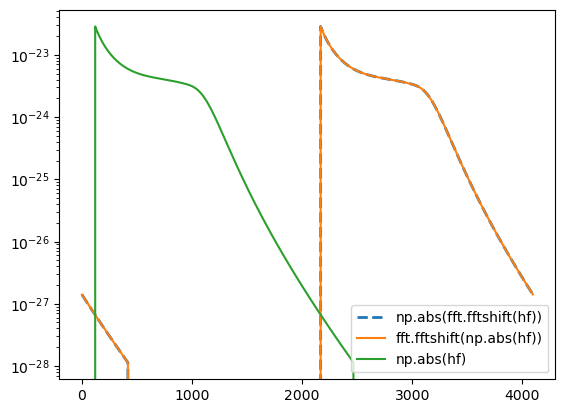

In [44]:
# Plot the frequency domain signal
plt.plot(np.abs(fft.fftshift(hf)),label="np.abs(fft.fftshift(hf))",
         linewidth=2,linestyle='dashed')
plt.plot(fft.fftshift(np.abs(hf)),label="fft.fftshift(np.abs(hf))")
plt.plot(np.abs(hf),label="np.abs(hf)")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [45]:
print("hf.shape:",hf.shape)
print("(4097-1)/16384=",(4097-1)/16384)
# with np.printoptions(edgeitems=10000):
#     print(hf)
#print(hf[(29*4):(40*4)])

for i in range(130):
    print(i,hf[i])
print(hf[-10:-1])

hf.shape: (4097,)
(4097-1)/16384= 0.25
0 0j
1 0j
2 0j
3 0j
4 0j
5 0j
6 0j
7 0j
8 0j
9 0j
10 0j
11 0j
12 0j
13 0j
14 0j
15 0j
16 0j
17 0j
18 0j
19 0j
20 0j
21 0j
22 0j
23 0j
24 0j
25 0j
26 0j
27 0j
28 0j
29 0j
30 0j
31 0j
32 0j
33 0j
34 0j
35 0j
36 0j
37 0j
38 0j
39 0j
40 0j
41 0j
42 0j
43 0j
44 0j
45 0j
46 0j
47 0j
48 0j
49 0j
50 0j
51 0j
52 0j
53 0j
54 0j
55 0j
56 0j
57 0j
58 0j
59 0j
60 0j
61 0j
62 0j
63 0j
64 0j
65 0j
66 0j
67 0j
68 0j
69 0j
70 0j
71 0j
72 0j
73 0j
74 0j
75 0j
76 0j
77 0j
78 0j
79 0j
80 0j
81 0j
82 0j
83 0j
84 0j
85 0j
86 0j
87 0j
88 0j
89 0j
90 0j
91 0j
92 0j
93 0j
94 0j
95 0j
96 0j
97 0j
98 0j
99 0j
100 0j
101 0j
102 0j
103 0j
104 0j
105 0j
106 0j
107 0j
108 0j
109 0j
110 0j
111 0j
112 0j
113 0j
114 0j
115 0j
116 0j
117 0j
118 0j
119 0j
120 (-3.4269893006430915e-24+2.837157610822781e-23j)
121 (-1.2734185172385781e-23+2.5239032540499763e-23j)
122 (-2.018208921599285e-23+1.9360507094819784e-23j)
123 (-2.510856632566056e-23+1.1626081846809285e-23j)
124 (-2.7211147895

fp=-0.08203431228266732, fc=-0.683443506564472


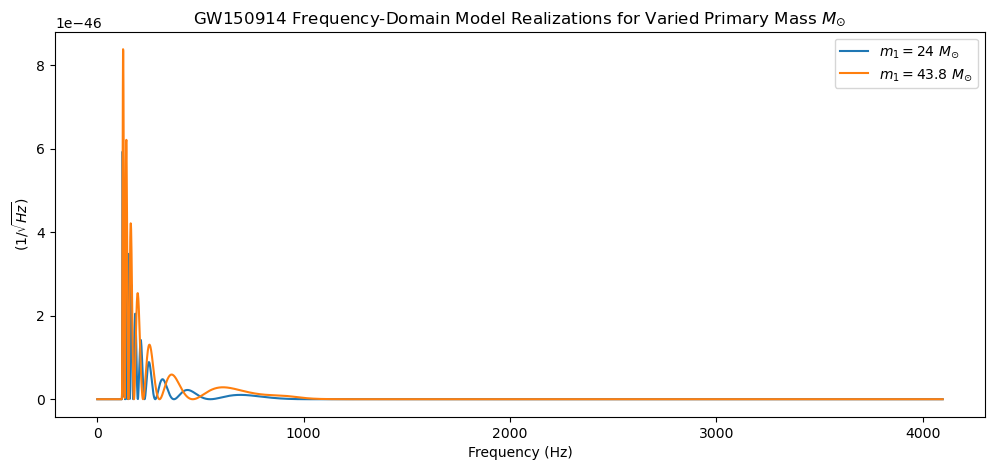

In [46]:
# Calculate the frequency-domain waveform for these model parameters
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_fd_waveform

# These attena pattern coefficients fp and fc allow us to project 
# a signal into what the detector would observe

# Time, orientation and location of the source in the sky
ra = 1.7473731391015275
dec = -1.1863113354482382
pol = 1.501041951560141
inc = 0.46524887993865477
time = 1126259462.423953

# We can calculate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))


# Initialize values
mass_1_array = np.linspace(24,43.8,100)
hf_all = np.zeros((100,4097))
index = 0

for current_mass_1 in mass_1_array:
    #print(mass_1_array)

    ## Generate a freq-domain model realization, the intrinsic signal
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", 
                             mass1=current_mass_1, 
                             mass2=31.8201770433512,
                             f_lower=30, 
                             delta_f=0.25, 
                             inclination=inc,
                             distance=454.23284333190617)

    ## Apply the factors to get the detector frame strain
    hf = fp * hp + fc * hc
    #print(index,hf.shape)
    hf_all[index,:] = hf
    index +=1

plt.figure(figsize=(12,5))
plt.plot(np.abs(hf_all[0])**2,label="$m_1=24$ $M_{\odot}$")
plt.plot(np.abs(hf_all[99])**2,label="$m_1=43.8$ $M_{\odot}$")
#plt.plot(hf_all)
plt.title("GW150914 Frequency-Domain Model Realizations for Varied \
Primary Mass $M_{\odot}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$(1/\sqrt{Hz})$")
# plt.xlim(100,1500)
# plt.xscale("log")
plt.legend()
plt.show()

In [47]:
print(hf_all[1,3500:3650])
print(hf_all.shape)
print(target_freq)
print(fft.ifftshift(target_freq))
print(target_freq)
print(fft.fftshift(target_freq))
print(target_freq)
print(noise_spectra_avg1024)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(100, 4097)
[-8192.   -8191.75 -8191.5  ...  8191.25  8191.5   8191.75]
[ 0.    0.25  0.5  ... -0.75 -0.5  -0.25]
[-8192.   -8191.75 -8191.5  ...  8191.25  8191.5   8191.75]
[ 0.    0.25  0.5  ... -0.75 -0.5  -0.25]
[-8192.   -8191.75 -8191.5  ...  8191.25  8191.5   8191.75]
[1.13960642e-49 1.32418715e-49 2.24790347e-49 ... 6.05817200e-49
 2.24790347e-49 1.32418715e-49]


## V. Parameter Estimation

- Use Bayesian analysis to calculate the likelihood that our noise signal (taken from near the event) is more than just noise
    - See equations 8 and 9 in the LIGO Guide


### V.A. Prepare Data Arrays for Parameter Estimation

In [48]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz # used to compute freq-domain filter

In [49]:
# Align the (1) frequency-domain PSD, (2) 100 model realizations, and
# (3) the windowed and FFTd GW150914 data to range from 0 to (512-0.25) Hz

target_freq_0to512 = fft.ifftshift(target_freq)[0:(512*4)]
print("target_freq_0to512:")
print(target_freq_0to512)
print(target_freq_0to512.shape,"\n")

psd_0to512 = noise_spectra_avg1024[0:(512*4)]
print("psd_0to512:")
print(psd_0to512)
print(psd_0to512.shape,"\n")

signal_spectrum_0to512 = (np.abs(target_strains_windowed_FFT)**2)[0:(512*4)]
print("signal_spectrum_0to512:")
print(signal_spectrum_0to512)
print(signal_spectrum_0to512.shape,"\n")

model_spectra_0to512 = (np.abs(hf_all)**2)[:,0:(512*4)]
print("model_spectra_0to512:")
print(model_spectra_0to512)
print(model_spectra_0to512.shape)

target_freq_0to512:
[0.0000e+00 2.5000e-01 5.0000e-01 ... 5.1125e+02 5.1150e+02 5.1175e+02]
(2048,) 

psd_0to512:
[1.13960642e-49 1.32418715e-49 2.24790347e-49 ... 5.72886349e-40
 5.69488939e-40 6.38861431e-40]
(2048,) 

signal_spectrum_0to512:
[1.21847049e-46 1.06928296e-46 7.10034438e-47 ... 4.93568307e-37
 1.01578402e-36 2.75272220e-37]
(2048,) 

model_spectra_0to512:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.75334646e-55
  8.55146279e-55 8.35385609e-55]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.24042835e-54
  6.14106401e-54 6.04329018e-54]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.46631874e-53
  1.44532412e-53 1.42463653e-53]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.57549165e-56
  2.54018266e-56 2.50537612e-56]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.09368389e-56
  3.05151456e-56 3.00994021e-56]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.56230075e-56
  3.51394963e-56 3.46627622e-56]]
(100, 2048)


In [50]:
np.abs(hf_all[10])**2

array([0., 0., 0., ..., 0., 0., 0.])

### V.B. Create and Apply Butterworth Bandpass Filter to Arrays

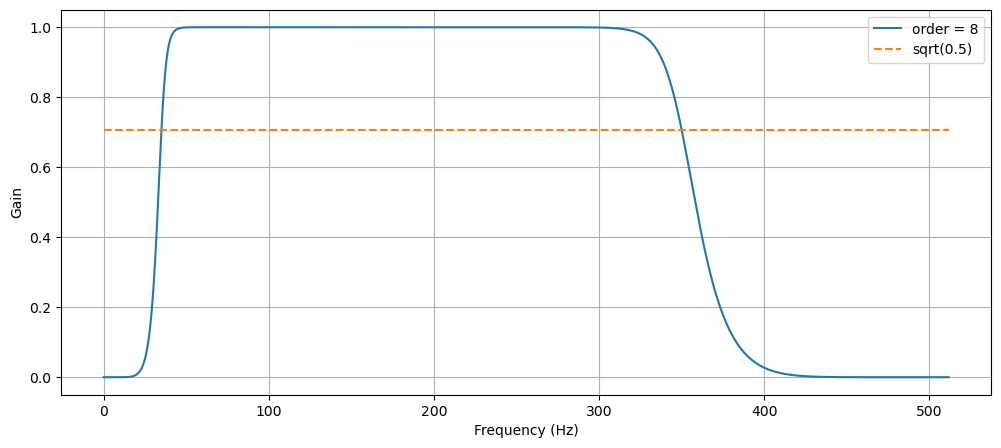

In [51]:
# fs = sampling frequency of the time-series data
# nyq = Nyquist frequency, half of the sampling frequency
# order = order of the filter
# lowcut = the lower value of the length-2 Wn window argument;
#          if fs is not specified, this is a fraction of nyq btwn 0 and 1;
#          if fs is specified, this is in the same units as fs btwn 0 
# highcut = the upper value of the length-2 Wn window argument
#           (same notes as for lowcut)
# b = numerator polynomial of IIR filter
# a = denominator polynomial of IIR filter

# worN = number of points to include in the freq-domain filter plot;
#        this should equal the size of other freq-domain arrays
# w = angular frequencies at which h was computed; 
#     in Hertz f = w*(fs/(2*np.pi))
# h = the (complex) frequency response
# y = output array of the filtering process

fs = 1024     # Omit?
nyq = 0.5 * fs # needed?
lowcut = 35/nyq   # should this be entered as a fraction of nyq instead?
highcut = 350/nyq  # ditto
order = 8

# Define the polynomials that are used to create a Butterworth 
# bandpass filter
b, a = butter(order, [lowcut, highcut], btype='band') #, fs=0.25)

# Create the bandpass filter in the frequency domain
w, h = freqz(b, a, worN=2048)
    
plt.figure(figsize=(12,5))
plt.plot((w*fs / (2*np.pi)), abs(h), label="order = 8")
plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.show()


For now let's ignore the fact that the w values of frequency arent the actual frequency-domain values since the array is the right size (2048).

In [52]:
print(w)
print(w.shape)

[0.00000000e+00 1.53398079e-03 3.06796158e-03 ... 3.13699071e+00
 3.13852469e+00 3.14005867e+00]
(2048,)


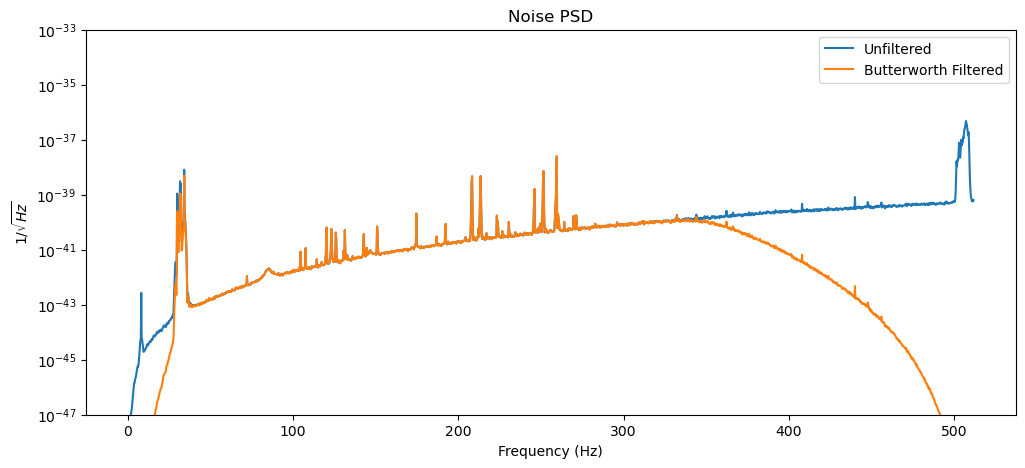

In [53]:
# Butterworth bandpass filter to the Welch-averaged noise PSD

psd_0to512_pe_ready = psd_0to512 * np.abs(h)

# Filtered vs unfiltered comparison plot

plt.figure(figsize=(12,5))
plt.plot(target_freq_0to512,psd_0to512,label="Unfiltered")
plt.plot(target_freq_0to512,psd_0to512_pe_ready,label="Butterworth Filtered")
plt.yscale("log")
plt.title("Noise PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$1/\sqrt{Hz}$")
plt.ylim(1e-47,1e-33)
plt.legend()
plt.show()

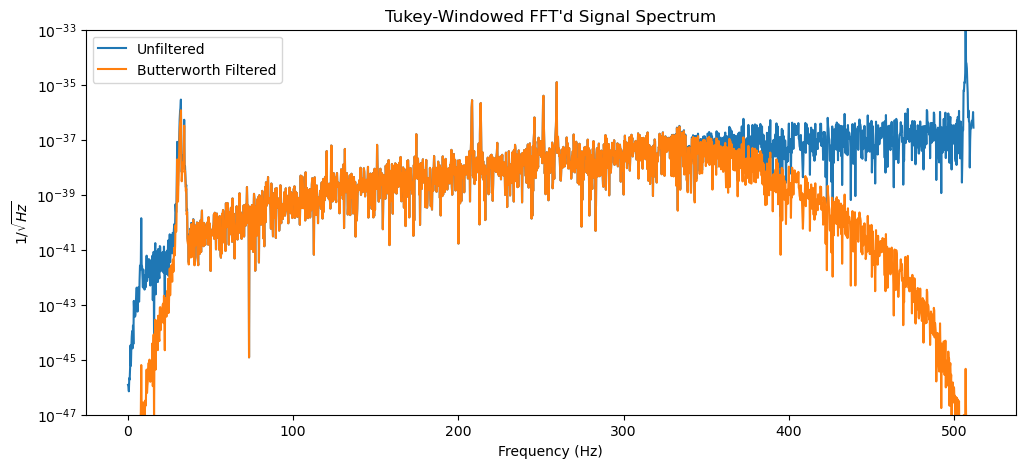

In [54]:
# Butterworth bandpass filter to the Tukey-Windowed FFT'd signal

signal_spectrum_0to512_pe_ready = signal_spectrum_0to512 * np.abs(h)

# Filtered vs unfiltered comparison plot

plt.figure(figsize=(12,5))
plt.plot(target_freq_0to512,signal_spectrum_0to512,label="Unfiltered")
plt.plot(target_freq_0to512,signal_spectrum_0to512_pe_ready,
         label="Butterworth Filtered")
plt.yscale("log")
plt.title("Tukey-Windowed FFT'd Signal Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$1/\sqrt{Hz}$")
plt.ylim(1e-47,1e-33)
plt.legend()
plt.show()

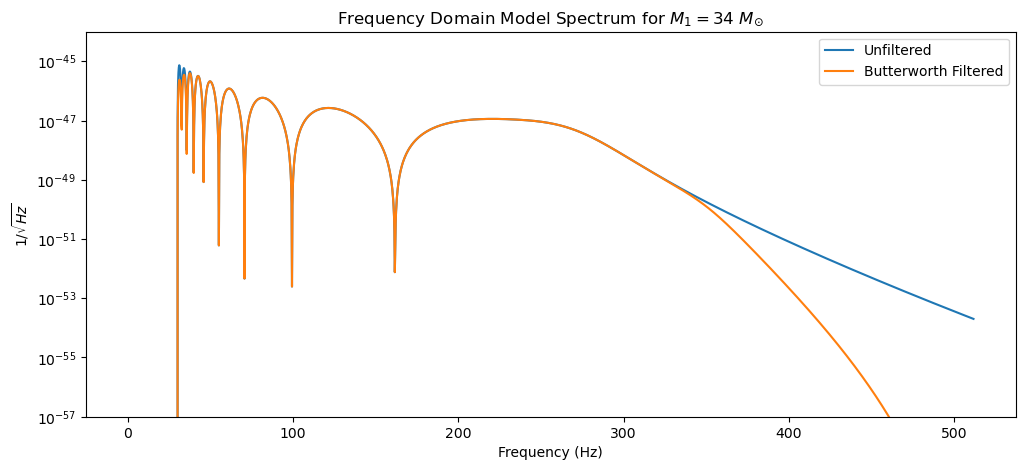

In [55]:
# Butterworth bandpass filter to the freq-domain model spectra

model_spectra_0to512_pe_ready = model_spectra_0to512 * np.abs(h)
# should this be the absolute value?

# Filtered vs unfiltered comparison plot

plt.figure(figsize=(12,5))
plt.plot(target_freq_0to512,model_spectra_0to512[49],label="Unfiltered")
plt.plot(target_freq_0to512,model_spectra_0to512_pe_ready[49],
         label="Butterworth Filtered")
plt.yscale("log")
plt.title("Frequency Domain Model Spectrum for $M_1=34$ $M_{\odot}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$1/\sqrt{Hz}$")
plt.ylim(1e-57,1e-44)
plt.legend()
plt.savefig("Poster Presentation Docs/model_spectrum.png",
            bbox_inches='tight')
plt.show()

### V.C. Calculate the Likelihood for Each Model Realization

In [56]:
# Obtain complex versions of the detection spectrum  
# (signal_spectrum_0to512_pe_ready) and model spectra 
# (model_spectra_0to512_pe_ready)

signal_spectrum_0to512_complex = target_strains_windowed_FFT[0:(512*4)]
print("signal_spectrum_0to512_complex:")
print(signal_spectrum_0to512_complex)
print(signal_spectrum_0to512_complex.shape,"\n")

signal_spectrum_0to512_complex_pe_ready = \
    signal_spectrum_0to512_complex * np.abs(h)
print("signal_spectrum_0to512_complex_pe_ready:")
print(signal_spectrum_0to512_complex_pe_ready)
print(signal_spectrum_0to512_complex_pe_ready.shape,"\n")

model_spectra_0to512_complex = hf_all[:,0:(512*4)] # Truly complex?
print("model_spectra_0to512_complex:")
print(model_spectra_0to512_complex)
print(model_spectra_0to512_complex.shape)

model_spectra_0to512_complex_pe_ready = \
    model_spectra_0to512_complex * np.abs(h)
print("model_spectra_0to512_complex_pe_ready:")
print(model_spectra_0to512_complex_pe_ready)
print(model_spectra_0to512_complex_pe_ready.shape)

signal_spectrum_0to512_complex:
[-1.10384351e-23-0.00000000e+00j -9.98083467e-24+2.70392962e-24j
 -6.65442447e-24+5.16934026e-24j ... -4.68556303e-19+5.23472348e-19j
  1.00775060e-18+1.49246419e-20j -4.24557808e-19-3.08257826e-19j]
(2048,) 

signal_spectrum_0to512_complex_pe_ready:
[-6.92218499e-36-0.00000000e+00j -5.21642769e-35+1.41319376e-35j
 -1.04423616e-35+8.11191416e-36j ... -2.38384713e-36+2.66324035e-36j
  3.84547949e-36+5.69509995e-38j -5.82851610e-36-4.23189885e-36j]
(2048,) 

model_spectra_0to512_complex:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.35593206e-28
  -9.24741195e-28 -9.13994316e-28]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.49808494e-27
  -2.47811703e-27 -2.45831043e-27]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.82925416e-27
  -3.80174187e-27 -3.77443576e-27]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.60483384e-28
  -1.59379505e-28 -1.58283799e-28]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ..

(100,)


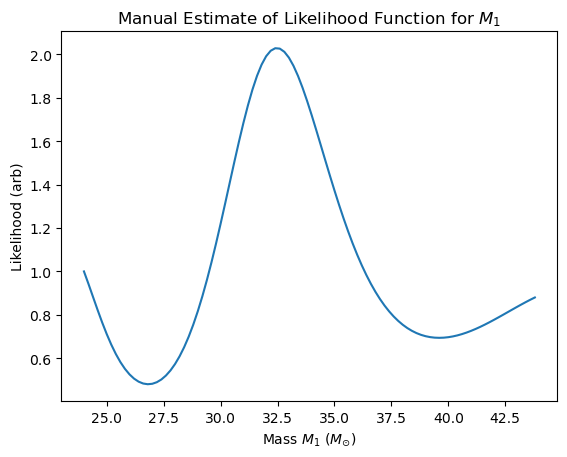

In [57]:
# = np.sum((np.abs(d-h))**2)/Sn(f)*0.25

likelihoods = np.zeros(100)

mass_1_array = np.linspace(24,43.8,100)

for i in range(100):
    #print(i,model_spectra_0to512_pe_ready[i].shape)
    likelihoods[i] = (np.sum
                      (((np.abs(signal_spectrum_0to512_complex_pe_ready 
                               - 
                               model_spectra_0to512_complex_pe_ready[i]
                              ))**2) /
                      psd_0to512_pe_ready)*0.25)
print(likelihoods.shape)
#plt.plot(mass_1_array,likelihoods)
plt.plot(mass_1_array,np.exp(likelihoods-likelihoods[0]))
plt.title("Manual Estimate of Likelihood Function for $M_1$")
plt.xlabel("Mass $M_1$ ($M_{\odot}$)")
plt.ylabel("Likelihood (arb)")
#plt.yticks([])
plt.savefig("Poster Presentation Docs/likelihood_function.png",
            bbox_inches='tight')
plt.show()

In [58]:
# Calulate the true likelihoods from the (mislabeled) log likelihoods
true_likelihoods = np.exp(likelihoods-likelihoods[0])

# Calculate the PDF of this likelihood function
likelihood_pdf = true_likelihoods/np.trapz(
    true_likelihoods,mass_1_array)

# Calculate the CDF of this likelihood function

likelihood_cdf = np.cumsum(likelihood_pdf)*(mass_1_array[1]-
                                            mass_1_array[0])
print(likelihood_cdf)

# Find the 25%, 50%, 75% percentiles

m1_25 = np.interp(0.25,likelihood_cdf,mass_1_array)
m1_50 = np.interp(0.50,likelihood_cdf,mass_1_array)
m1_75 = np.interp(0.75,likelihood_cdf,mass_1_array)

# Establish the credible intervals

m1_median = m1_50
m1_minus = m1_50-m1_25
m1_plus = m1_75-m1_50
print(m1_median)
print(m1_minus)
print(m1_plus)

[0.00987043 0.01916893 0.02787471 0.03599101 0.04354079 0.05056194
 0.05710273 0.06321783 0.06896518 0.07440365 0.07959157 0.08458591
 0.08944199 0.09421357 0.0989532  0.10371276 0.10854413 0.11349978
 0.11863345 0.12400067 0.12965917 0.13566914 0.14209325 0.14899638
 0.156445   0.16450621 0.1732464  0.18272938 0.19301422 0.20415276
 0.21618689 0.22914583 0.24304349 0.25787621 0.2736211  0.29023504
 0.30765467 0.3257973  0.34456288 0.36383679 0.38349343 0.40340027
 0.42342224 0.44342603 0.46328405 0.48287798 0.50210159 0.5208628
 0.5390849  0.55670714 0.57368447 0.58998686 0.60559805 0.62051412
 0.63474179 0.64829673 0.6612018  0.67348551 0.68518049 0.69632226
 0.7069481  0.71709614 0.72680459 0.73611118 0.74505273 0.75366481
 0.76198152 0.77003536 0.77785718 0.78547615 0.79291975 0.80021385
 0.80738275 0.81444925 0.82143476 0.82835935 0.83524182 0.84209978
 0.8489497  0.85580695 0.86268584 0.86959969 0.87656082 0.88358056
 0.89066927 0.89783635 0.90509024 0.91243837 0.91988719 0.92744

In [59]:
mass_1_array

array([24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. ,
       26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. , 28.2,
       28.4, 28.6, 28.8, 29. , 29.2, 29.4, 29.6, 29.8, 30. , 30.2, 30.4,
       30.6, 30.8, 31. , 31.2, 31.4, 31.6, 31.8, 32. , 32.2, 32.4, 32.6,
       32.8, 33. , 33.2, 33.4, 33.6, 33.8, 34. , 34.2, 34.4, 34.6, 34.8,
       35. , 35.2, 35.4, 35.6, 35.8, 36. , 36.2, 36.4, 36.6, 36.8, 37. ,
       37.2, 37.4, 37.6, 37.8, 38. , 38.2, 38.4, 38.6, 38.8, 39. , 39.2,
       39.4, 39.6, 39.8, 40. , 40.2, 40.4, 40.6, 40.8, 41. , 41.2, 41.4,
       41.6, 41.8, 42. , 42.2, 42.4, 42.6, 42.8, 43. , 43.2, 43.4, 43.6,
       43.8])

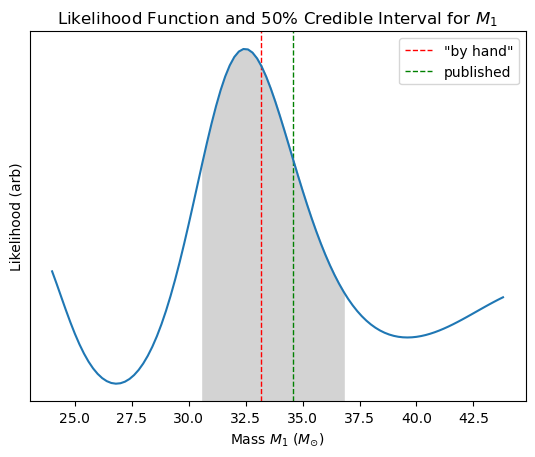

In [60]:
plt.fill_between(mass_1_array,np.exp(likelihoods-likelihoods[0]),
                 0.4,where=(mass_1_array>m1_25) & 
                 (mass_1_array<m1_75),color='lightgrey')
plt.axvline(x = m1_median, color = 'r', label = '"by hand"',
            linewidth=1, linestyle='dashed')
plt.axvline(x = 34.6, color = 'g', label = 'published',
            linewidth=1, linestyle='dashed')
plt.plot(mass_1_array,np.exp(likelihoods-likelihoods[0]))
plt.title("Likelihood Function and 50% Credible Interval for $M_1$")
plt.xlabel("Mass $M_1$ ($M_{\odot}$)")
plt.ylabel("Likelihood (arb)")
plt.ylim(0.4,)
plt.yticks([])
plt.legend()
plt.savefig("Poster Presentation Docs/likelihood_function_credible.png",
            bbox_inches='tight')
plt.show()

In [61]:
np.exp(likelihoods-likelihoods[0]).argmax()
mass_1_array[likelihoods.argmax()]

32.4

In [62]:
hf.shape

(4097,)

This next cell keeps crashing (matrix dimension issues again)

In [63]:
# Calculate the frequency-domain waveform for these model parameters
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_fd_waveform

# These attena patter coefficients fp and fc allow us to project 
# a signal into what the detector would observe

# Time, orientation and location of the source in the sky
ra = 1.7473731391015275
dec = -1.1863113354482382
pol = 1.501041951560141
inc = 0.46524887993865477
time = 1126259462.423953

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))


# Initialize values
# mass_1_array = np.linspace(24,43.8,100)
chirp_mass_array = np.linspace(20,40,100)
each_mass = 0.5*chirp_mass_array*4**(3/5)
hf_all = np.zeros((100,4097))
index = 0

for current_masses in each_mass:
    #print(mass_1_array)

    ## Generate a freq-domain model realization, the intrinsic signal
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", 
                             mass1=current_masses, 
                             mass2=current_masses,
                             f_lower=30, 
                             delta_f=0.25, 
                             inclination=inc,
                             distance=454.23284333190617)

    ## Apply the factors to get the detector frame strain
    hf = fp * hp + fc * hc
    #print(index,hf.shape)
    hf_all[index,:] = hf
    index +=1

# plt.figure(figsize=(12,5))
# plt.plot(np.abs(hf_all[0])**2,label="$m_1=24$ $M_{\odot}$")
# plt.plot(np.abs(hf_all[99])**2,label="$m_1=43.8$ $M_{\odot}$")
# #plt.plot(hf_all)
# plt.title("GW150914 Frequency-Domain Model Realizations for Varied \
# Primary Mass $M_{\odot}$")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("$(1/\sqrt{Hz})$")
# # plt.xlim(100,1500)
# # plt.xscale("log")
# plt.legend()
# plt.show()


fp=-0.08203431228266732, fc=-0.683443506564472


ValueError: could not broadcast input array from shape (2049,) into shape (4097,)

---

## Graveyard

Is this why down sampling is necessary?

In [ ]:
# fs = sampling frequency of the time-series data
# nyq = Nyquist frequency, half of the sampling frequency
# order = order of the filter
# lowcut = the lower value of the length-2 Wn window argument;
#          if fs is not specified, this is a fraction of nyq btwn 0 and 1;
#          if fs is specified, this is in the same units as fs btwn 0 
# highcut = the upper value of the length-2 Wn window argument
#           (same notes as for lowcut)
# b = numerator polynomial of IIR filter
# a = denominator polynomial of IIR filter

# worN = number of points to include in the freq-domain filter plot;
#        this should equal the size of other freq-domain arrays
# w = angular frequencies at which h was computed; 
#     in Hertz f = w*(fs/(2*np.pi))
# h = the (complex) frequency response
# y = output array of the filtering process

# fs = 1024     # Omit?
# nyq = 0.5 * fs # needed?
fmax = 4096 # the maximum freq value of our frequency domain
lowcut = 35/fmax   # should this be entered as a fraction of nyq instead?
highcut = 350/fmax  # ditto
order = 8

# Define the polynomials that are used to create a Butterworth 
# bandpass filter
b, a = butter(order, [lowcut, highcut], btype='band') #, fs=0.25)

# Create the bandpass filter in the frequency domain
w, h = freqz(b, a, worN=2048)
    
plt.figure(figsize=(12,5))
plt.plot((w*fmax / (2*np.pi)), abs(h), label="order = 8")
plt.plot([0, 0.5 * fmax], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.xlim(0,400)
plt.show()
